# This notebook contains training step and analysis using nmae result...

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, GenericUnivariateSelect
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold

import xgboost as xgb

In [2]:
# Normalized Mean Absolute Error
def nmae(y_pred, y_test):
    mae = mean_absolute_error(y_test, y_pred)
    mean_true = np.mean(np.abs(y_test))
    return (mae / mean_true)

def normalized_mean_absolute_error(y_true, y_pred):
    """
    Calculates the Normalized Mean Absolute Error (NMAE).

    Args:
        y_true (array-like): Ground truth (correct) target values.
        y_pred (array-like): Estimated target values.

    Returns:
        float: The Normalized Mean Absolute Error.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length.")

    mae = np.mean(np.abs(y_true - y_pred))

    # Calculate the range of actual values
    y_range = np.max(y_true) - np.min(y_true)

    # Avoid division by zero if the range is zero
    if y_range == 0:
        return 0.0 if mae == 0 else np.inf
    else:
        nmae = mae / y_range
        return nmae

def print_scores(scores, name="NMAE"):
    """
    Prints cross-validation scores returned by cross_val_score.
    Since error scorers in sklearn are usually negative (greater_is_better=False),
    this function converts them to positive percentages.
    """
    scores_pct = -scores * 100  # convert to positive percentage

    print(f"{name} per fold:")
    for i, s in enumerate(scores_pct):
        print(f"  Fold {i+1}: {s:.2f}%")

    print(f"\nMean {name}: {np.mean(scores_pct):.2f}%")

In [3]:
# Load write dataset t100
x_t100 = pd.read_csv('datasets/exp90c_2h/t100/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_t100.shape)
x_t100.head(5)

(7803, 1814)


timestamp  container_blkio_device_usage_total_0  \
0  1764169108                             159993856   
1  1764169109                             159993856   
2  1764169110                             159993856   
3  1764169111                             159993856   
4  1764169112                             159993856   

   container_blkio_device_usage_total_1  container_blkio_device_usage_total_2  \
0                             914415616                             159993856   
1                             914415616                             159993856   
2                             914415616                             159993856   
3                             914415616                             159993856   
4                             914415616                             159993856   

   container_blkio_device_usage_total_3  container_blkio_device_usage_total_4  \
0                             390885376                             133115904   
1                             390885376                             133115904   
2                             390885376                             133115904   
3                             390885376                             133115904   
4                             390885376                             133115904   

   container_blkio_device_usage_total_5  container_blkio_device_usage_total_6  \
0                              56868864                             133115904   
1                              56868864                             133115904   
2                              56868864                             133115904   
3                              56868864                             133115904   
4                              56893440                             133115904   

   container_blkio_device_usage_total_7  container_blkio_device_usage_total_8  \
0                              32018432                             157319168   
1                              32018432                             157319168   
2                              32018432                             157319168   
3                              32018432                             157319168   
4                              32038912                             157319168   

   ...  network_transmit_bytes_per_container_30  \
0  ...                             44510.231924   
1  ...                             44901.848592   
2  ...                             38717.200474   
3  ...                             40600.000000   
4  ...                             26422.011984   

   network_transmit_bytes_per_container_31  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   network_transmit_bytes_per_container_32  \
0                             15200.902256   
1                             10193.190129   
2                             13547.567954   
3                              9137.531668   
4                             11597.381718   

   network_transmit_bytes_per_container_33  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   network_transmit_bytes_per_container_34  \
0                             40409.437208   
1                             28944.520782   
2                             36490.822972   
3                             42328.008245   
4                             43061.615102   

   network_transmit_bytes_per_container_35  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   network_transmit_bytes_per_con

In [4]:
# Load y t100
y_t100 = pd.read_csv('datasets/exp90c_2h/t100/20251126_145828678_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t100.shape)
y_t100.head(5)

(7803, 45)


timestamp  queries_num  queries_requested  errors_occurred  \
0  1764169108            0                  0                0   
1  1764169109            9                  0                0   
2  1764169110           17                  0                0   
3  1764169111           24                  0                0   
4  1764169112           31                  0                0   

   iter_errors_occurred  average_latency  99_9_latency_percentile  mean_rate  \
0                     0                0                        0   0.000000   
1                     0               24                        2   0.059300   
2                     0               15                        2   0.111278   
3                     0               12                        2   0.156077   
4                     0               10                        2   0.200297   

   one_minute_rate  five_minute_rate  ...  w_min  w_max     w_mean  w_std_dev  \
0              0.0               0.0  ...      0      0   0.000000   0.000000   
1              0.0               0.0  ...      5     83  24.333333  33.462666   
2              0.0               0.0  ...      4     83  15.812500  26.400047   
3              0.0               0.0  ...      4     83  12.041667  22.008850   
4              0.0               0.0  ...      4     83  10.354839  19.532108   

   w_median  w_75th_percentile  w_95th_percentile  w_98th_percentile  \
0       0.0                0.0                0.0                0.0   
1       7.0               39.0               83.0               83.0   
2       5.5                7.0               83.0               83.0   
3       5.0                6.0               83.0               83.0   
4       5.0                6.0               83.0               83.0   

   w_99th_percentile  w_99_9th_percentile  
0                0.0                    0  
1               83.0                   83  
2               83.0                   83  
3               83.0                   83  
4               83.0                   83  

[5 rows x 45 columns]

In [41]:
# Load write dataset t300
x_t300 = pd.read_csv('datasets/exp90c_2h/t300/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_t300.shape)
x_t300.head(5)

(7803, 1814)


timestamp  container_blkio_device_usage_total_0  \
0  1764179120                             159993856   
1  1764179121                             159993856   
2  1764179122                             159993856   
3  1764179123                             159993856   
4  1764179124                             159993856   

   container_blkio_device_usage_total_1  container_blkio_device_usage_total_2  \
0                            3684048896                             159993856   
1                            3684048896                             159993856   
2                            3684048896                             159993856   
3                            3684061184                             159993856   
4                            3684061184                             159993856   

   container_blkio_device_usage_total_3  container_blkio_device_usage_total_4  \
0                            2965762048                             133124096   
1                            2965762048                             133124096   
2                            2965762048                             133124096   
3                            2965774336                             133124096   
4                            2965774336                             133124096   

   container_blkio_device_usage_total_5  container_blkio_device_usage_total_6  \
0                            2815647744                             133124096   
1                            2815647744                             133124096   
2                            2815647744                             133124096   
3                            2815647744                             133124096   
4                            2815647744                             133124096   

   container_blkio_device_usage_total_7  container_blkio_device_usage_total_8  \
0                            2599342080                             157319168   
1                            2599342080                             157319168   
2                            2599342080                             157319168   
3                            2599342080                             157319168   
4                            2599342080                             157319168   

   ...  network_transmit_bytes_per_container_30  \
0  ...                             38240.798503   
1  ...                             36757.866347   
2  ...                             21196.642866   
3  ...                             37945.201238   
4  ...                             51774.111675   

   network_transmit_bytes_per_container_31  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   network_transmit_bytes_per_container_32  \
0                             12492.717847   
1                             11369.355201   
2                             11411.459508   
3                             10372.026251   
4                             11913.330193   

   network_transmit_bytes_per_container_33  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   network_transmit_bytes_per_container_34  \
0                             38975.777725   
1                             40354.473943   
2                             42361.445783   
3                             43193.643443   
4                             36151.995305   

   network_transmit_bytes_per_container_35  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   network_transmit_bytes_per_con

In [42]:
# Load y t300
y_t300 = pd.read_csv('datasets/exp90c_2h/t300/20251126_174520693_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t300.shape)
y_t300.head(5)

(7803, 45)


timestamp  queries_num  queries_requested  errors_occurred  \
0  1764179120            0                  0                0   
1  1764179121            9                  0                0   
2  1764179122           17                  0                0   
3  1764179123           24                  0                0   
4  1764179124           31                  0                0   

   iter_errors_occurred  average_latency  99_9_latency_percentile  mean_rate  \
0                     0                0                        0   0.000000   
1                     0                6                        2   0.059583   
2                     0                5                        2   0.111805   
3                     0                4                        2   0.156811   
4                     0                4                        2   0.201233   

   one_minute_rate  five_minute_rate  ...  w_min  w_max    w_mean  w_std_dev  \
0              0.0               0.0  ...      0      0  0.000000   0.000000   
1              0.0               0.0  ...      3     17  6.666667   5.873670   
2              0.0               0.0  ...      3     17  5.437500   4.530912   
3              0.0               0.0  ...      3     17  4.791667   3.787613   
4              0.0               0.0  ...      3     17  4.548387   3.354983   

   w_median  w_75th_percentile  w_95th_percentile  w_98th_percentile  \
0       0.0           0.000000                0.0                0.0   
1       4.0           8.333333               17.0               17.0   
2       4.0           4.000000               17.0               17.0   
3       4.0           4.000000               17.0               17.0   
4       4.0           4.000000               17.0               17.0   

   w_99th_percentile  w_99_9th_percentile  
0                0.0                    0  
1               17.0                   17  
2               17.0                   17  
3               17.0                   17  
4               17.0                   17  

[5 rows x 45 columns]

In [43]:
# Load write dataset t500
x_t500 = pd.read_csv('datasets/exp90c_2h/t500/prometheus_metrics_wide.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(x_t500.shape)
x_t500.head(5)

(7803, 1814)


timestamp  container_blkio_device_usage_total_0  \
0  1764198786                             159993856   
1  1764198787                             160047104   
2  1764198788                             160047104   
3  1764198789                             160047104   
4  1764198790                             160047104   

   container_blkio_device_usage_total_1  container_blkio_device_usage_total_2  \
0                           11839750144                             159993856   
1                           11839811584                             160047104   
2                           11839811584                             160047104   
3                           11839815680                             160047104   
4                           11839815680                             160047104   

   container_blkio_device_usage_total_3  container_blkio_device_usage_total_4  \
0                            9786974208                             133136384   
1                            9787035648                             133136384   
2                            9787035648                             133136384   
3                            9787035648                             133136384   
4                            9787035648                             133136384   

   container_blkio_device_usage_total_5  container_blkio_device_usage_total_6  \
0                           10936401920                             133136384   
1                           10936401920                             133136384   
2                           10936401920                             133136384   
3                           10936401920                             133136384   
4                           10936401920                             133136384   

   container_blkio_device_usage_total_7  container_blkio_device_usage_total_8  \
0                            9330151424                             157319168   
1                            9330151424                             157319168   
2                            9330151424                             157319168   
3                            9330151424                             157319168   
4                            9330151424                             157319168   

   ...  network_transmit_bytes_per_container_30  \
0  ...                             33379.752086   
1  ...                             39257.216164   
2  ...                             45954.058625   
3  ...                             45954.058625   
4  ...                             46674.205554   

   network_transmit_bytes_per_container_31  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   network_transmit_bytes_per_container_32  \
0                             10788.920455   
1                             12656.750000   
2                             11700.878410   
3                             12220.613082   
4                              9675.200611   

   network_transmit_bytes_per_container_33  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   network_transmit_bytes_per_container_34  \
0                             39880.103694   
1                             39880.103694   
2                             43284.507786   
3                             44117.868676   
4                             46040.415380   

   network_transmit_bytes_per_container_35  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   network_transmit_bytes_per_con

In [44]:
# Load y t500
y_t500 = pd.read_csv('datasets/exp90c_2h/t500/20251126_231306003_w.csv', low_memory=True).apply(pd.to_numeric, errors='coerce').fillna(0)
print(y_t500.shape)
y_t500.head(5)

(7803, 45)


timestamp  queries_num  queries_requested  errors_occurred  \
0  1764198786            0                  0                0   
1  1764198787            9                  0                0   
2  1764198788           17                  0                0   
3  1764198789           24                  0                0   
4  1764198790           32                  0                0   

   iter_errors_occurred  average_latency  99_9_latency_percentile  mean_rate  \
0                     0                0                        0   0.000000   
1                     0                5                        2   0.059581   
2                     0                4                        2   0.111801   
3                     0                4                        2   0.156806   
4                     0                4                        2   0.207717   

   one_minute_rate  five_minute_rate  ...  w_min  w_max    w_mean  w_std_dev  \
0              0.0               0.0  ...      0      0  0.000000   0.000000   
1              0.0               0.0  ...      4      6  5.111111   0.600925   
2              0.0               0.0  ...      4      6  4.812500   0.655108   
3              0.0               0.0  ...      4      6  4.625000   0.646899   
4              0.0               0.0  ...      4      6  4.612903   0.615219   

   w_median  w_75th_percentile  w_95th_percentile  w_98th_percentile  \
0       0.0           0.000000                0.0                0.0   
1       5.0           5.333333                6.0                6.0   
2       5.0           5.000000                6.0                6.0   
3       5.0           5.000000                6.0                6.0   
4       5.0           5.000000                6.0                6.0   

   w_99th_percentile  w_99_9th_percentile  
0                0.0                    0  
1                6.0                    6  
2                6.0                    6  
3                6.0                    6  
4                6.0                    6  

[5 rows x 45 columns]

# KDE for write dataset metrics

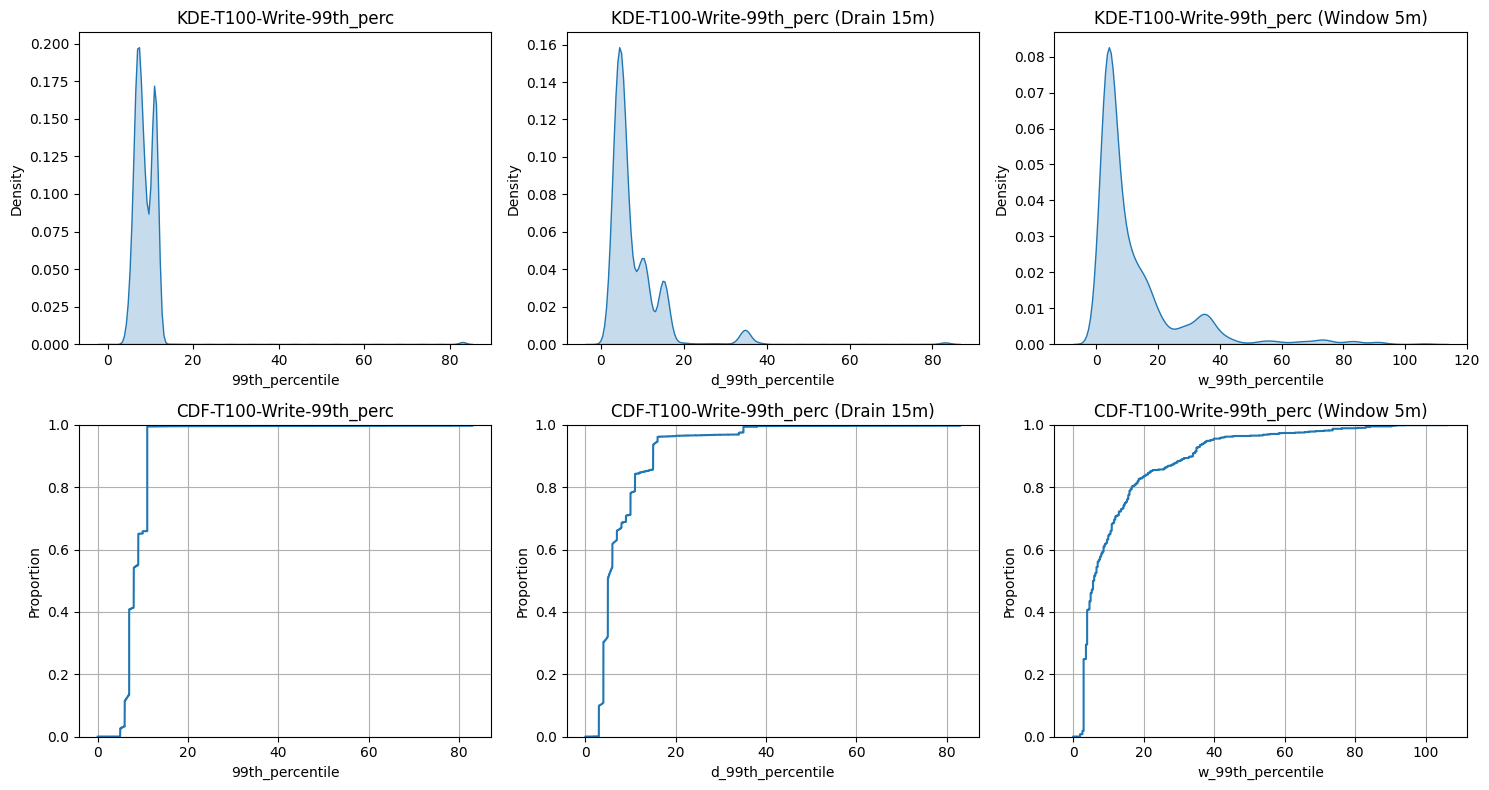

In [13]:
# 99th_percentile t100
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.kdeplot(y_t100['99th_percentile'],fill=True, ax=axes[0,0])
axes[0,0].set_title("KDE-T100-Write-99th_perc")

sns.kdeplot(y_t100['d_99th_percentile'],fill=True, ax=axes[0,1])
axes[0,1].set_title("KDE-T100-Write-99th_perc (Drain 15m)")

sns.kdeplot(y_t100['w_99th_percentile'],fill=True, ax=axes[0,2])
axes[0,2].set_title("KDE-T100-Write-99th_perc (Window 5m)")

sns.ecdfplot(data=y_t100, x='99th_percentile', ax=axes[1,0])
axes[1,0].set_title("CDF-T100-Write-99th_perc")
axes[1,0].grid(True)

sns.ecdfplot(data=y_t100, x='d_99th_percentile', ax=axes[1,1])
axes[1,1].set_title("CDF-T100-Write-99th_perc (Drain 15m)")
axes[1,1].grid(True)

sns.ecdfplot(data=y_t100, x='w_99th_percentile', ax=axes[1,2])
axes[1,2].set_title("CDF-T100-Write-99th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

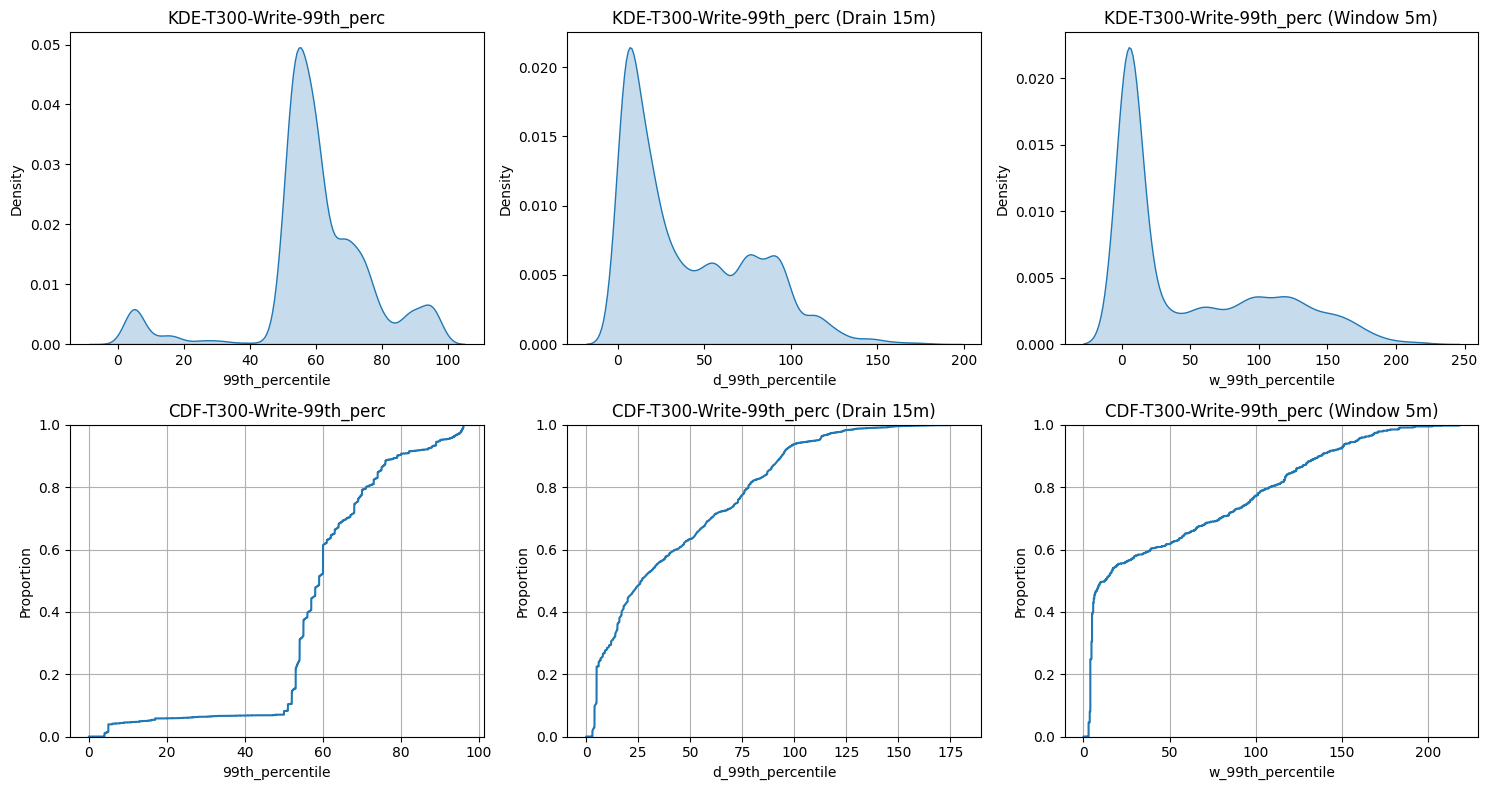

In [15]:
# 99th_percentile t300
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.kdeplot(y_t300['99th_percentile'],fill=True, ax=axes[0,0])
axes[0,0].set_title("KDE-T300-Write-99th_perc")

sns.kdeplot(y_t300['d_99th_percentile'],fill=True, ax=axes[0,1])
axes[0,1].set_title("KDE-T300-Write-99th_perc (Drain 15m)")

sns.kdeplot(y_t300['w_99th_percentile'],fill=True, ax=axes[0,2])
axes[0,2].set_title("KDE-T300-Write-99th_perc (Window 5m)")

sns.ecdfplot(data=y_t300, x='99th_percentile', ax=axes[1,0])
axes[1,0].set_title("CDF-T300-Write-99th_perc")
axes[1,0].grid(True)

sns.ecdfplot(data=y_t300, x='d_99th_percentile', ax=axes[1,1])
axes[1,1].set_title("CDF-T300-Write-99th_perc (Drain 15m)")
axes[1,1].grid(True)

sns.ecdfplot(data=y_t300, x='w_99th_percentile', ax=axes[1,2])
axes[1,2].set_title("CDF-T300-Write-99th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

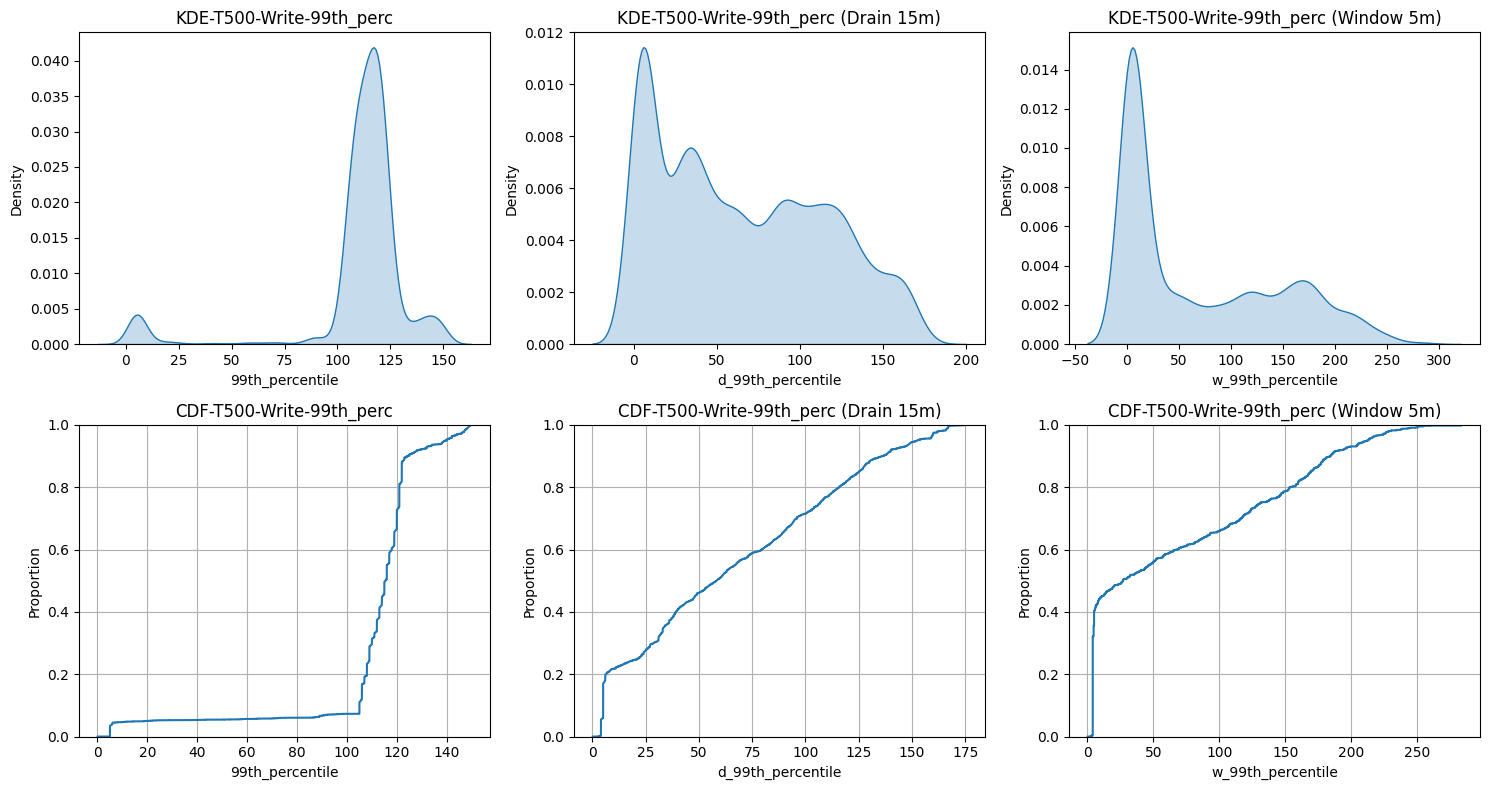

In [16]:
# 99th_percentile t500
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
sns.kdeplot(y_t500['99th_percentile'],fill=True, ax=axes[0,0])
axes[0,0].set_title("KDE-T500-Write-99th_perc")

sns.kdeplot(y_t500['d_99th_percentile'],fill=True, ax=axes[0,1])
axes[0,1].set_title("KDE-T500-Write-99th_perc (Drain 15m)")

sns.kdeplot(y_t500['w_99th_percentile'],fill=True, ax=axes[0,2])
axes[0,2].set_title("KDE-T500-Write-99th_perc (Window 5m)")

sns.ecdfplot(data=y_t500, x='99th_percentile', ax=axes[1,0])
axes[1,0].set_title("CDF-T500-Write-99th_perc")
axes[1,0].grid(True)

sns.ecdfplot(data=y_t500, x='d_99th_percentile', ax=axes[1,1])
axes[1,1].set_title("CDF-T500-Write-99th_perc (Drain 15m)")
axes[1,1].grid(True)

sns.ecdfplot(data=y_t500, x='w_99th_percentile', ax=axes[1,2])
axes[1,2].set_title("CDF-T500-Write-99th_perc (Window 5m)")
# axes[2].set_xlim(0.0, 50)
axes[1,2].grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [6]:
def get_select_k_best_ds(x, y, k):
    selector = SelectKBest(f_regression, k=k)
    k_best_ds = selector.fit_transform(x, y)

    # Get a boolean mask of selected features
    selected_features_mask = selector.get_support()

    # Get the names of the selected features
    selected_feature_names = x.columns[selected_features_mask]
    print(selected_feature_names)

    k_best_ds = pd.DataFrame(k_best_ds, columns=selected_feature_names, index=x.index)
    print(k_best_ds.shape)
    k_best_ds.head(5)
    return k_best_ds

# Random Forest training using all features and k best features...

## train 70%, test 30%

In [37]:
def kfold_train_and_generate_plots(X, y, y_col, kfold, title, image_path):
    random_forest_model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)
    
    # Set up K-fold cross-validation
    kf = KFold(n_splits=kfold, shuffle=True, random_state=42) # 5

    scores = []
    fig, axes = plt.subplots(kfold, 2, figsize=(15, 20))
    time = datetime.datetime.now(tz=datetime.timezone.utc)

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Create splits
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx][y_col], y.iloc[test_idx][y_col]
    
        sns.ecdfplot(data=y, x=y_col, label='y', ax=axes[fold,0])
        sns.ecdfplot(x=y_train, label=f'y_train_{fold}', ax=axes[fold,0])
        sns.ecdfplot(x=y_test, label=f'y_test_{fold}', ax=axes[fold,0])
        axes[fold,0].set_title(f"CDF-{title}-F{fold}")
        axes[fold,0].grid(True)
        axes[fold,0].legend()
    
        sns.kdeplot(y[y_col],fill=True, label='y', ax=axes[fold,1])
        sns.kdeplot(y_train,fill=True, label=f'y_train_{fold}', ax=axes[fold,1])
        sns.kdeplot(y_test,fill=True, label=f'y_test_{fold}', ax=axes[fold,1])
        axes[fold,1].set_title(f"KDE-{title}-F{fold}")
        axes[fold,1].legend()
    
        # Train model
        random_forest_model.fit(X_train, y_train)
    
        # Predict
        y_pred = random_forest_model.predict(X_test)
    
        # Compute NMAE
        nmae_value = nmae(y_pred, y_test)
    
        scores.append(nmae_value)
    
    print(f'T100 - Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')
    
    for i, s in enumerate(scores):
        print(f"Fold {i+1}: {s:.2%}")
    
    print(f"Mean NMAE: {np.mean(scores):.2%}\n")

    plt.tight_layout()
    plt.show()

    fig.savefig(f'{image_path}/{title}.png', dpi=fig.dpi, format='png')

## T100

T100 - Rand. Forest Training time: 102.194784s
Fold 1: 0.77%
Fold 2: 0.22%
Fold 3: 0.29%
Fold 4: 0.81%
Fold 5: 0.27%
Mean NMAE: 0.47%



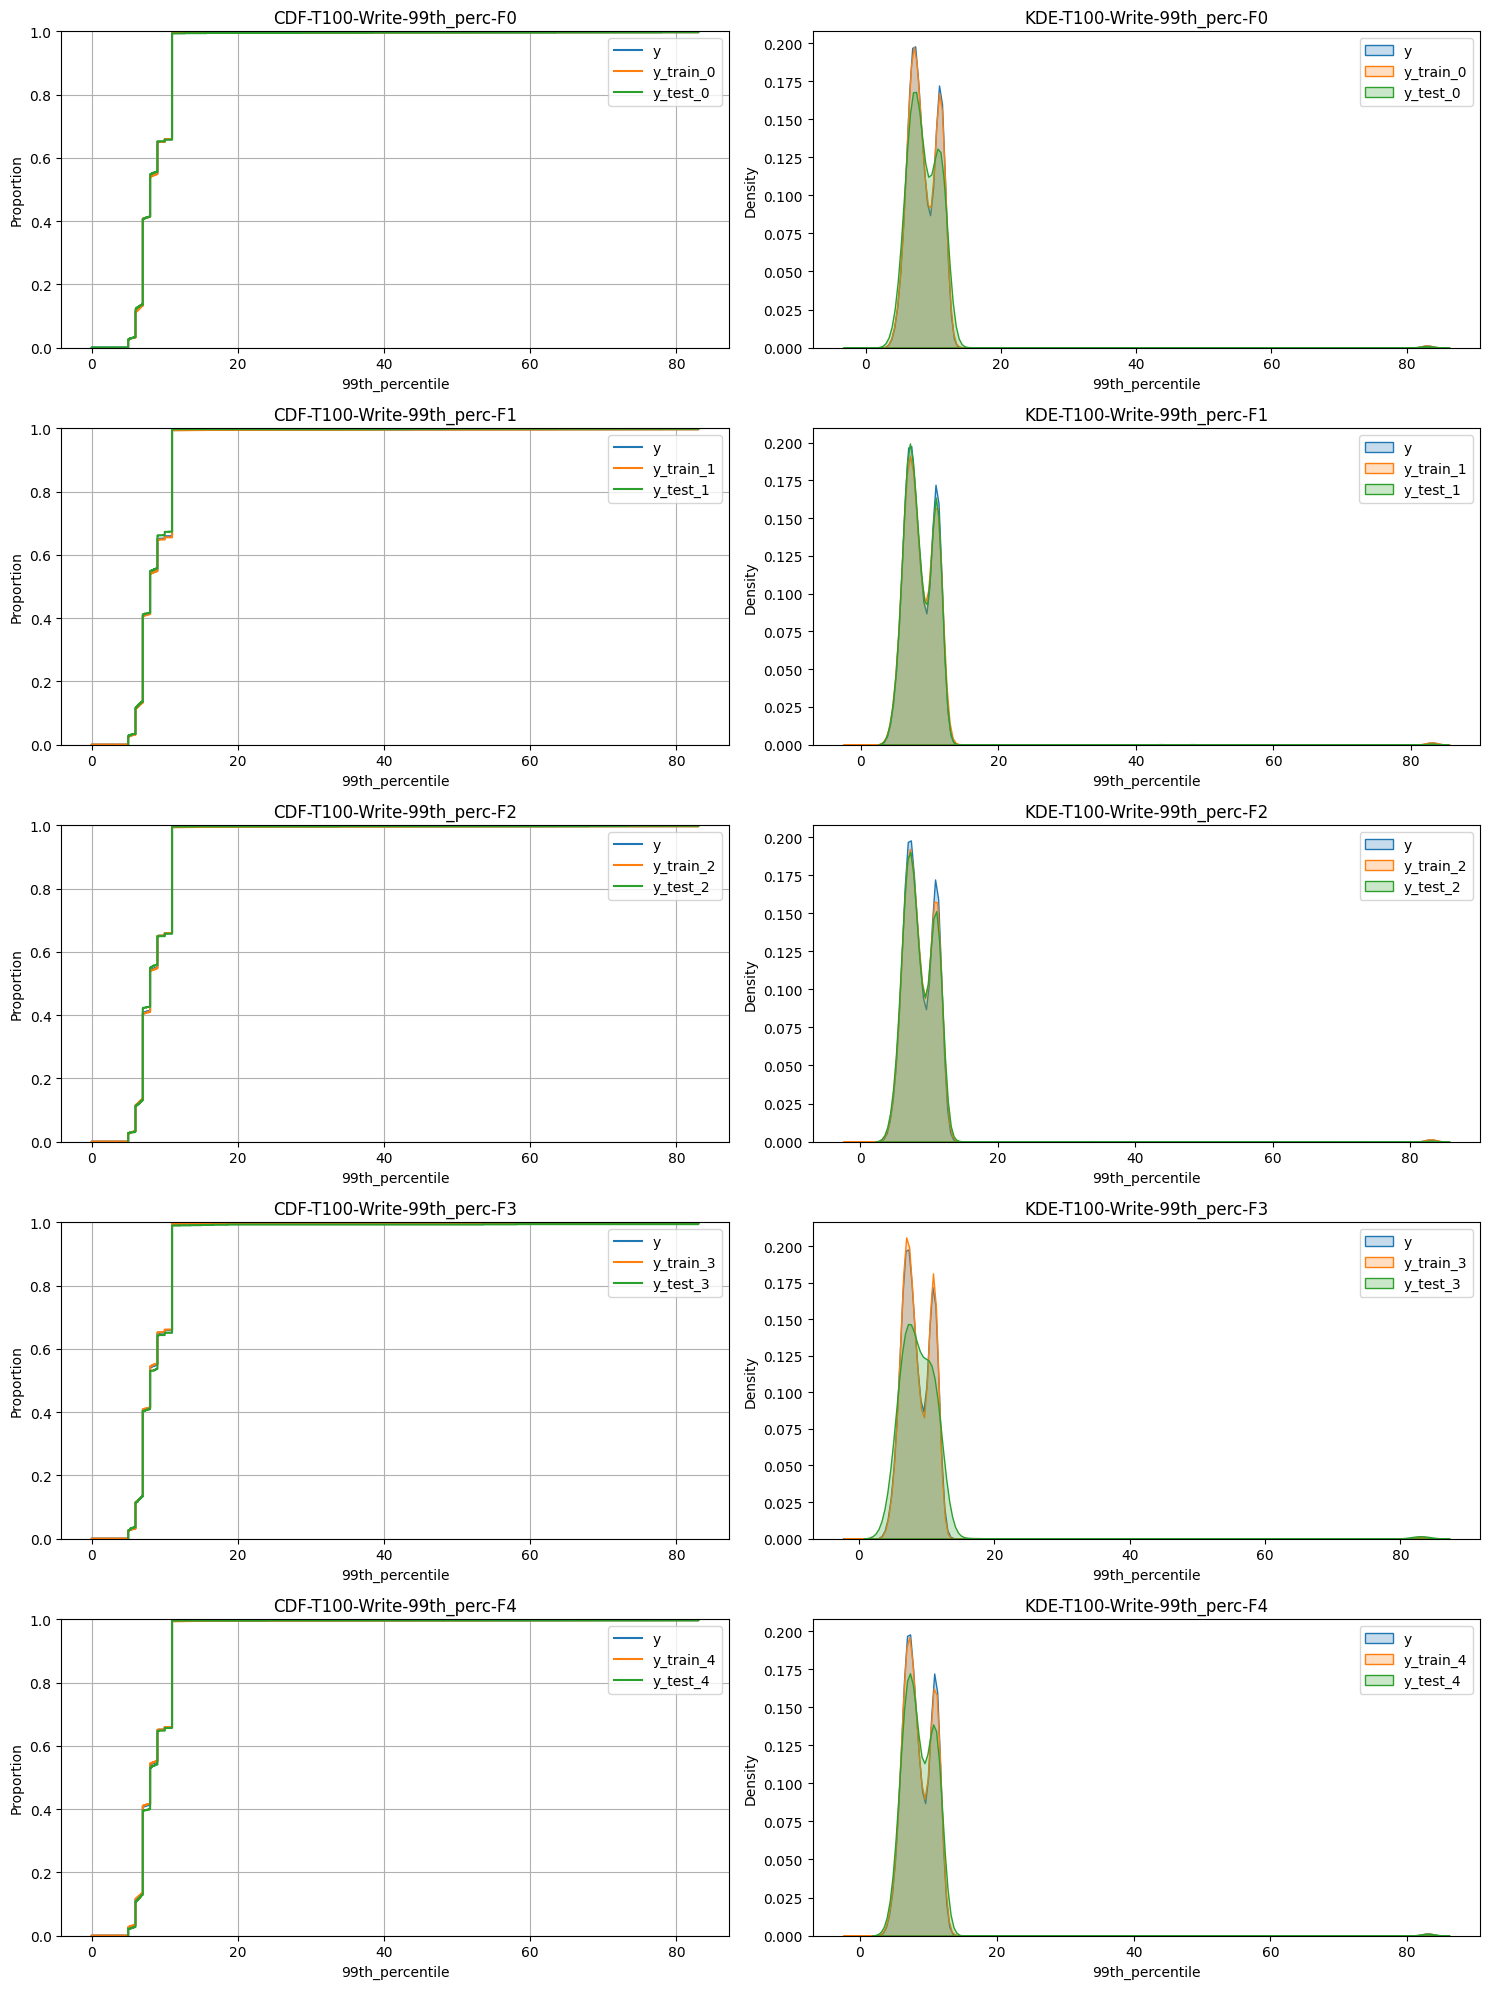

In [35]:
# Full dataset - wihout normalization...
kfold_train_and_generate_plots(x_t100, y_t100, "99th_percentile", 5, "T100-Write-99th_perc", "images/exp_90c_2h")

T100 - Rand. Forest Training time: 154.873789s
Fold 1: 2.73%
Fold 2: 1.96%
Fold 3: 2.44%
Fold 4: 2.58%
Fold 5: 2.17%
Mean NMAE: 2.37%



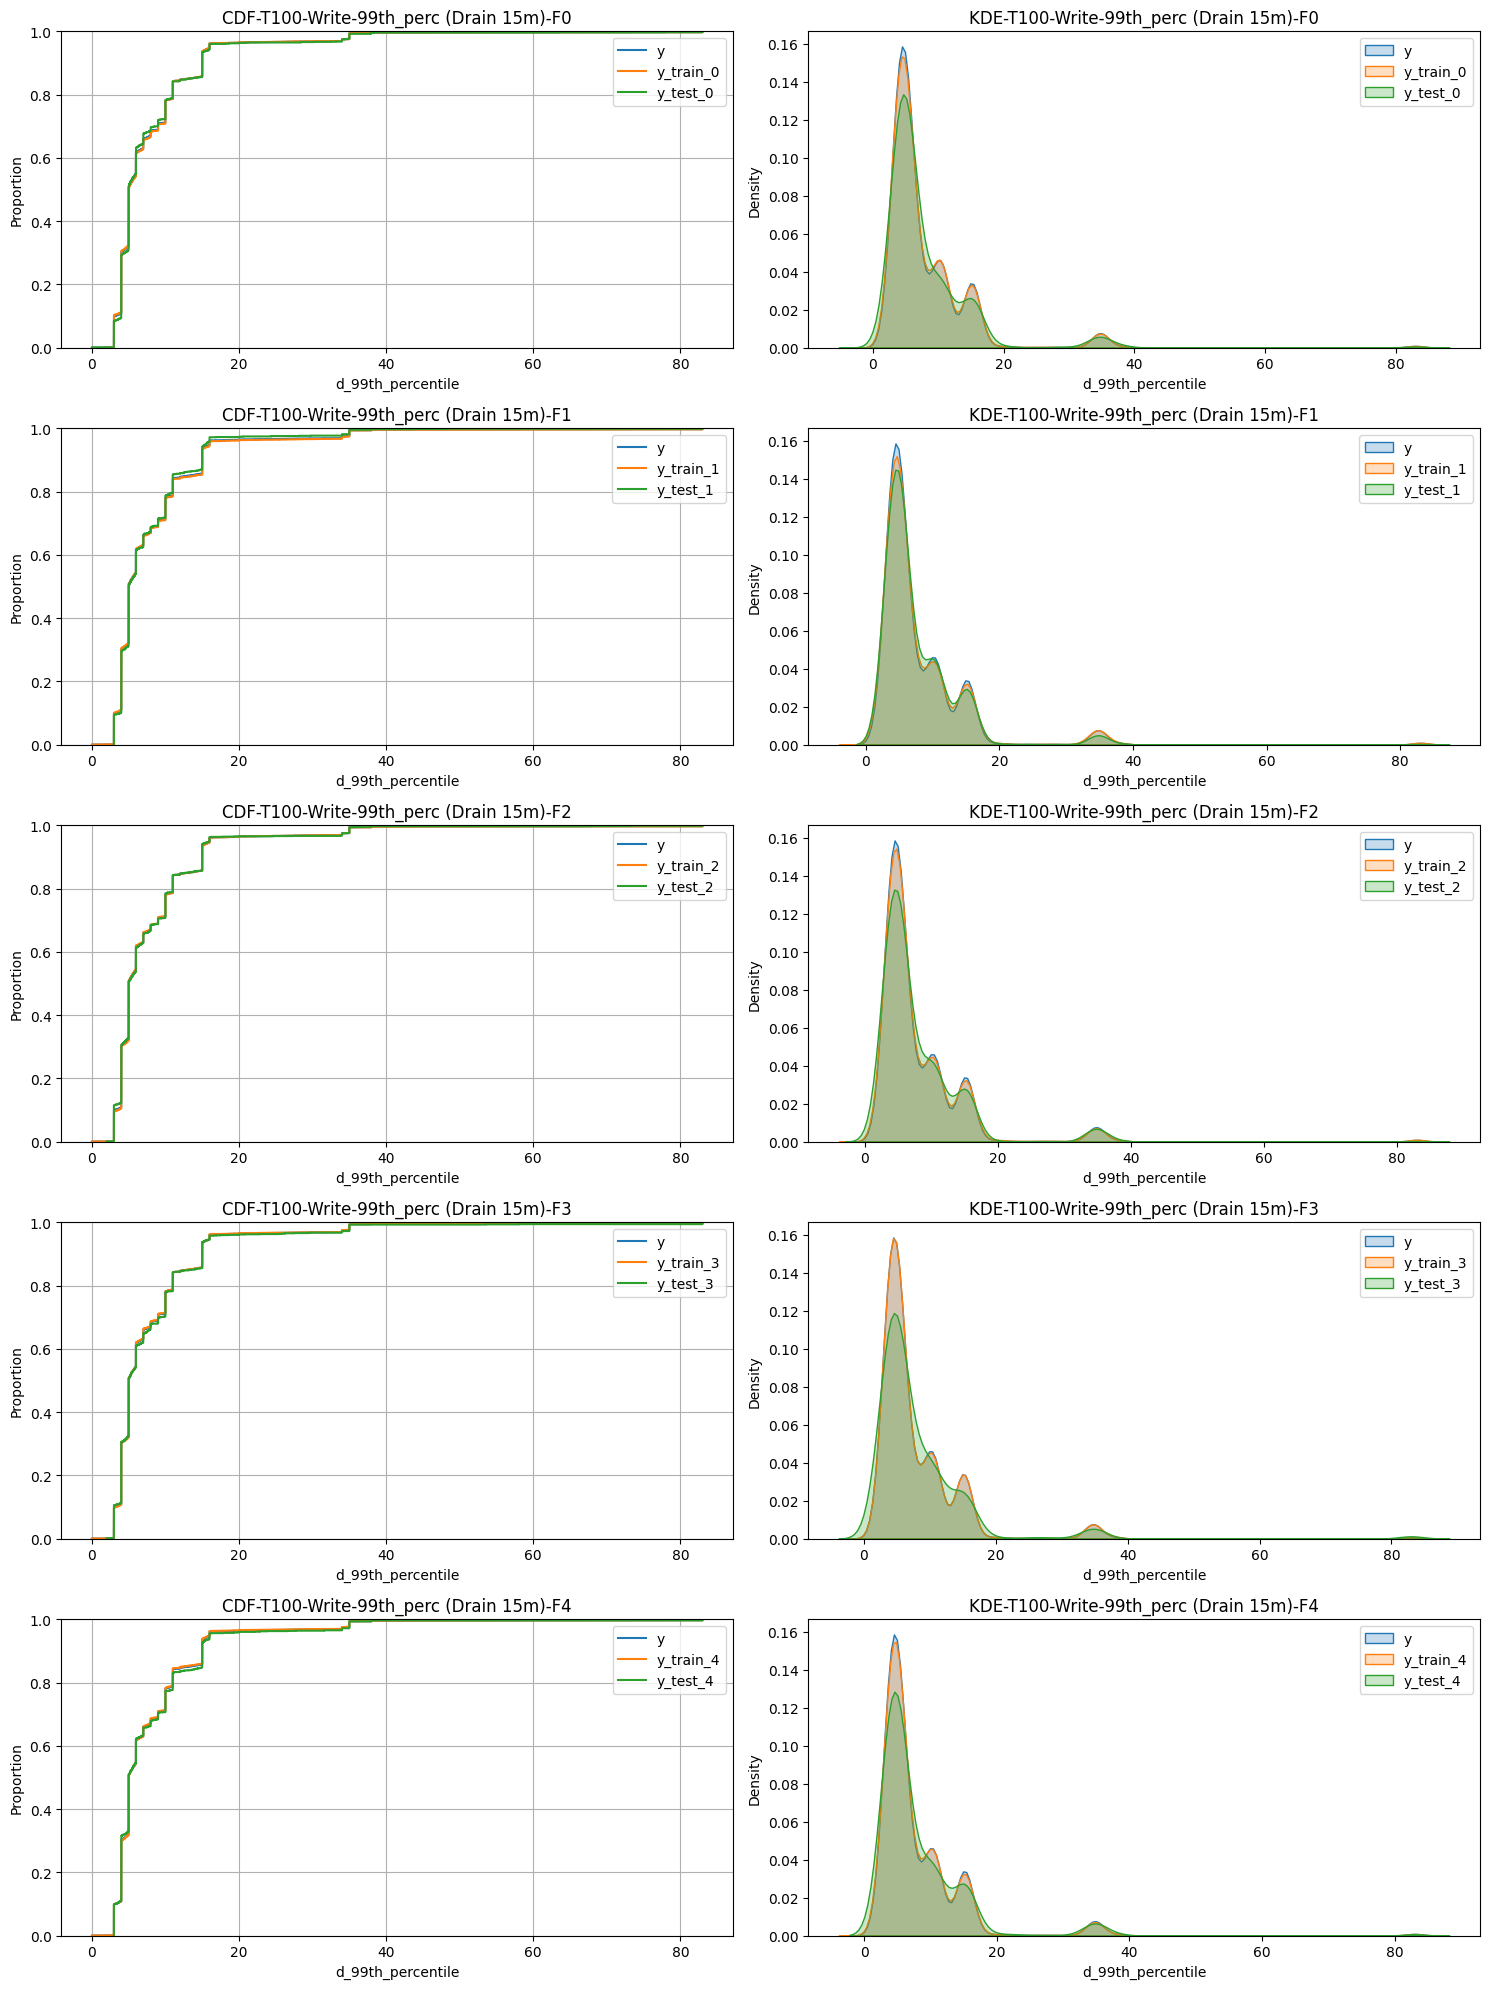

In [38]:
kfold_train_and_generate_plots(x_t100, y_t100, "d_99th_percentile", 5, "T100-Write-99th_perc (Drain 15m)", "images/exp_90c_2h")

T100 - Rand. Forest Training time: 179.469372s
Fold 1: 15.78%
Fold 2: 14.70%
Fold 3: 14.75%
Fold 4: 14.98%
Fold 5: 14.35%
Mean NMAE: 14.91%



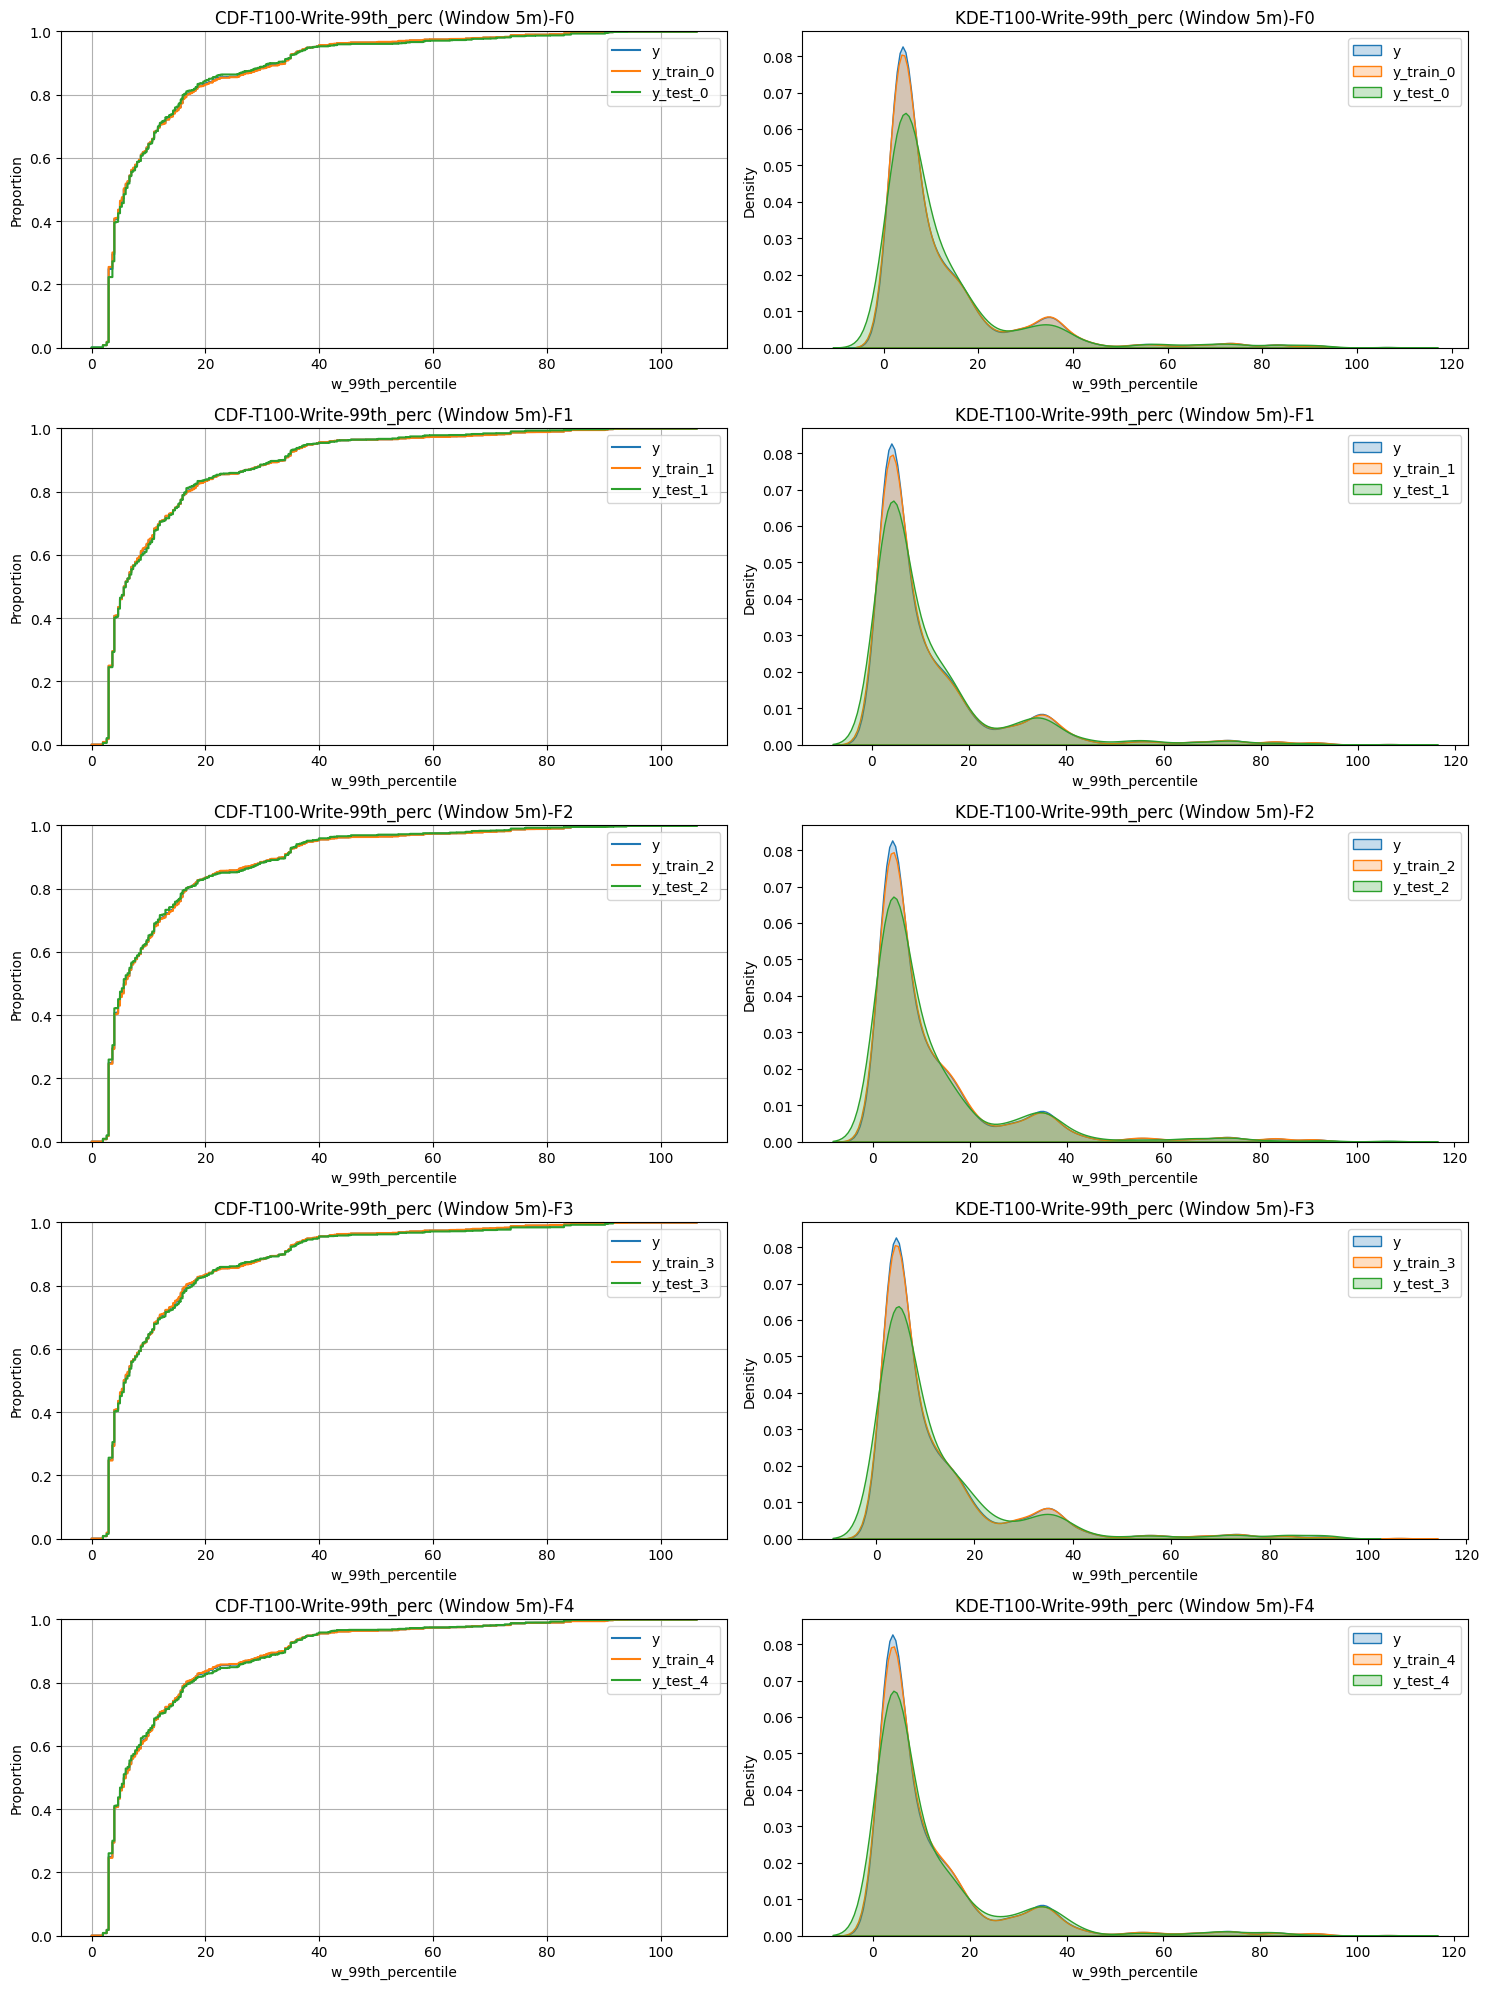

In [39]:
kfold_train_and_generate_plots(x_t100, y_t100, "w_99th_percentile", 5, "T100-Write-99th_perc (Window 5m)", "images/exp_90c_2h")

## T300

T100 - Rand. Forest Training time: 127.860473s
Fold 1: 0.18%
Fold 2: 0.13%
Fold 3: 0.14%
Fold 4: 0.17%
Fold 5: 0.13%
Mean NMAE: 0.15%



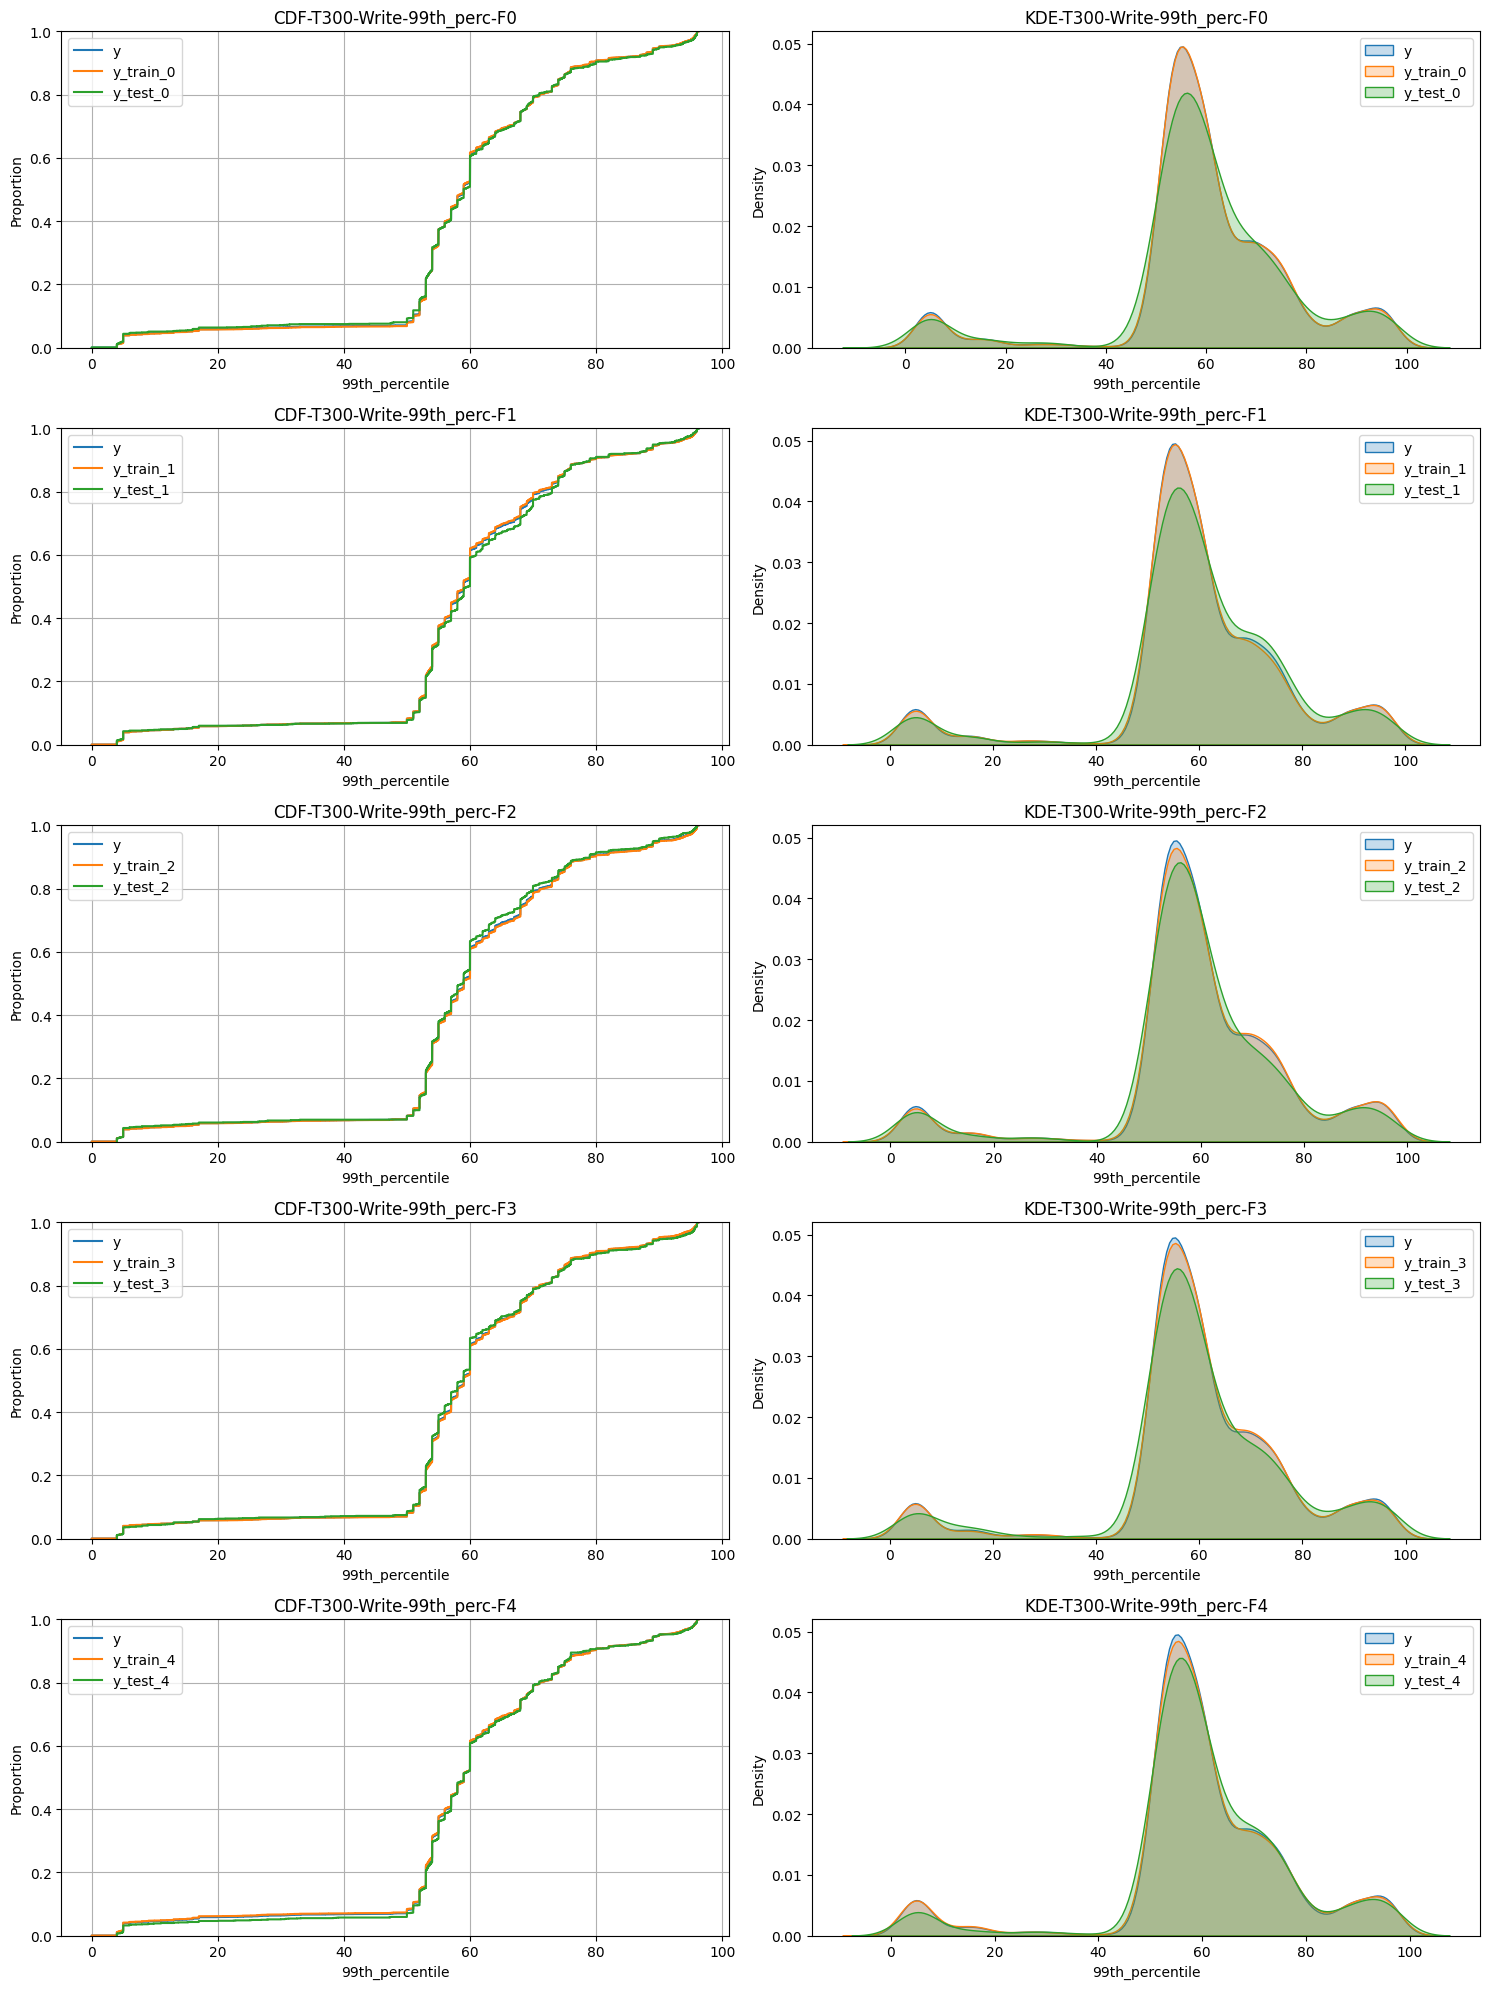

In [45]:
# Full dataset - wihout normalization...
kfold_train_and_generate_plots(x_t300, y_t300, "99th_percentile", 5, "T300-Write-99th_perc", "images/exp_90c_2h")

T100 - Rand. Forest Training time: 145.712908s
Fold 1: 1.65%
Fold 2: 1.86%
Fold 3: 2.08%
Fold 4: 2.09%
Fold 5: 2.05%
Mean NMAE: 1.95%



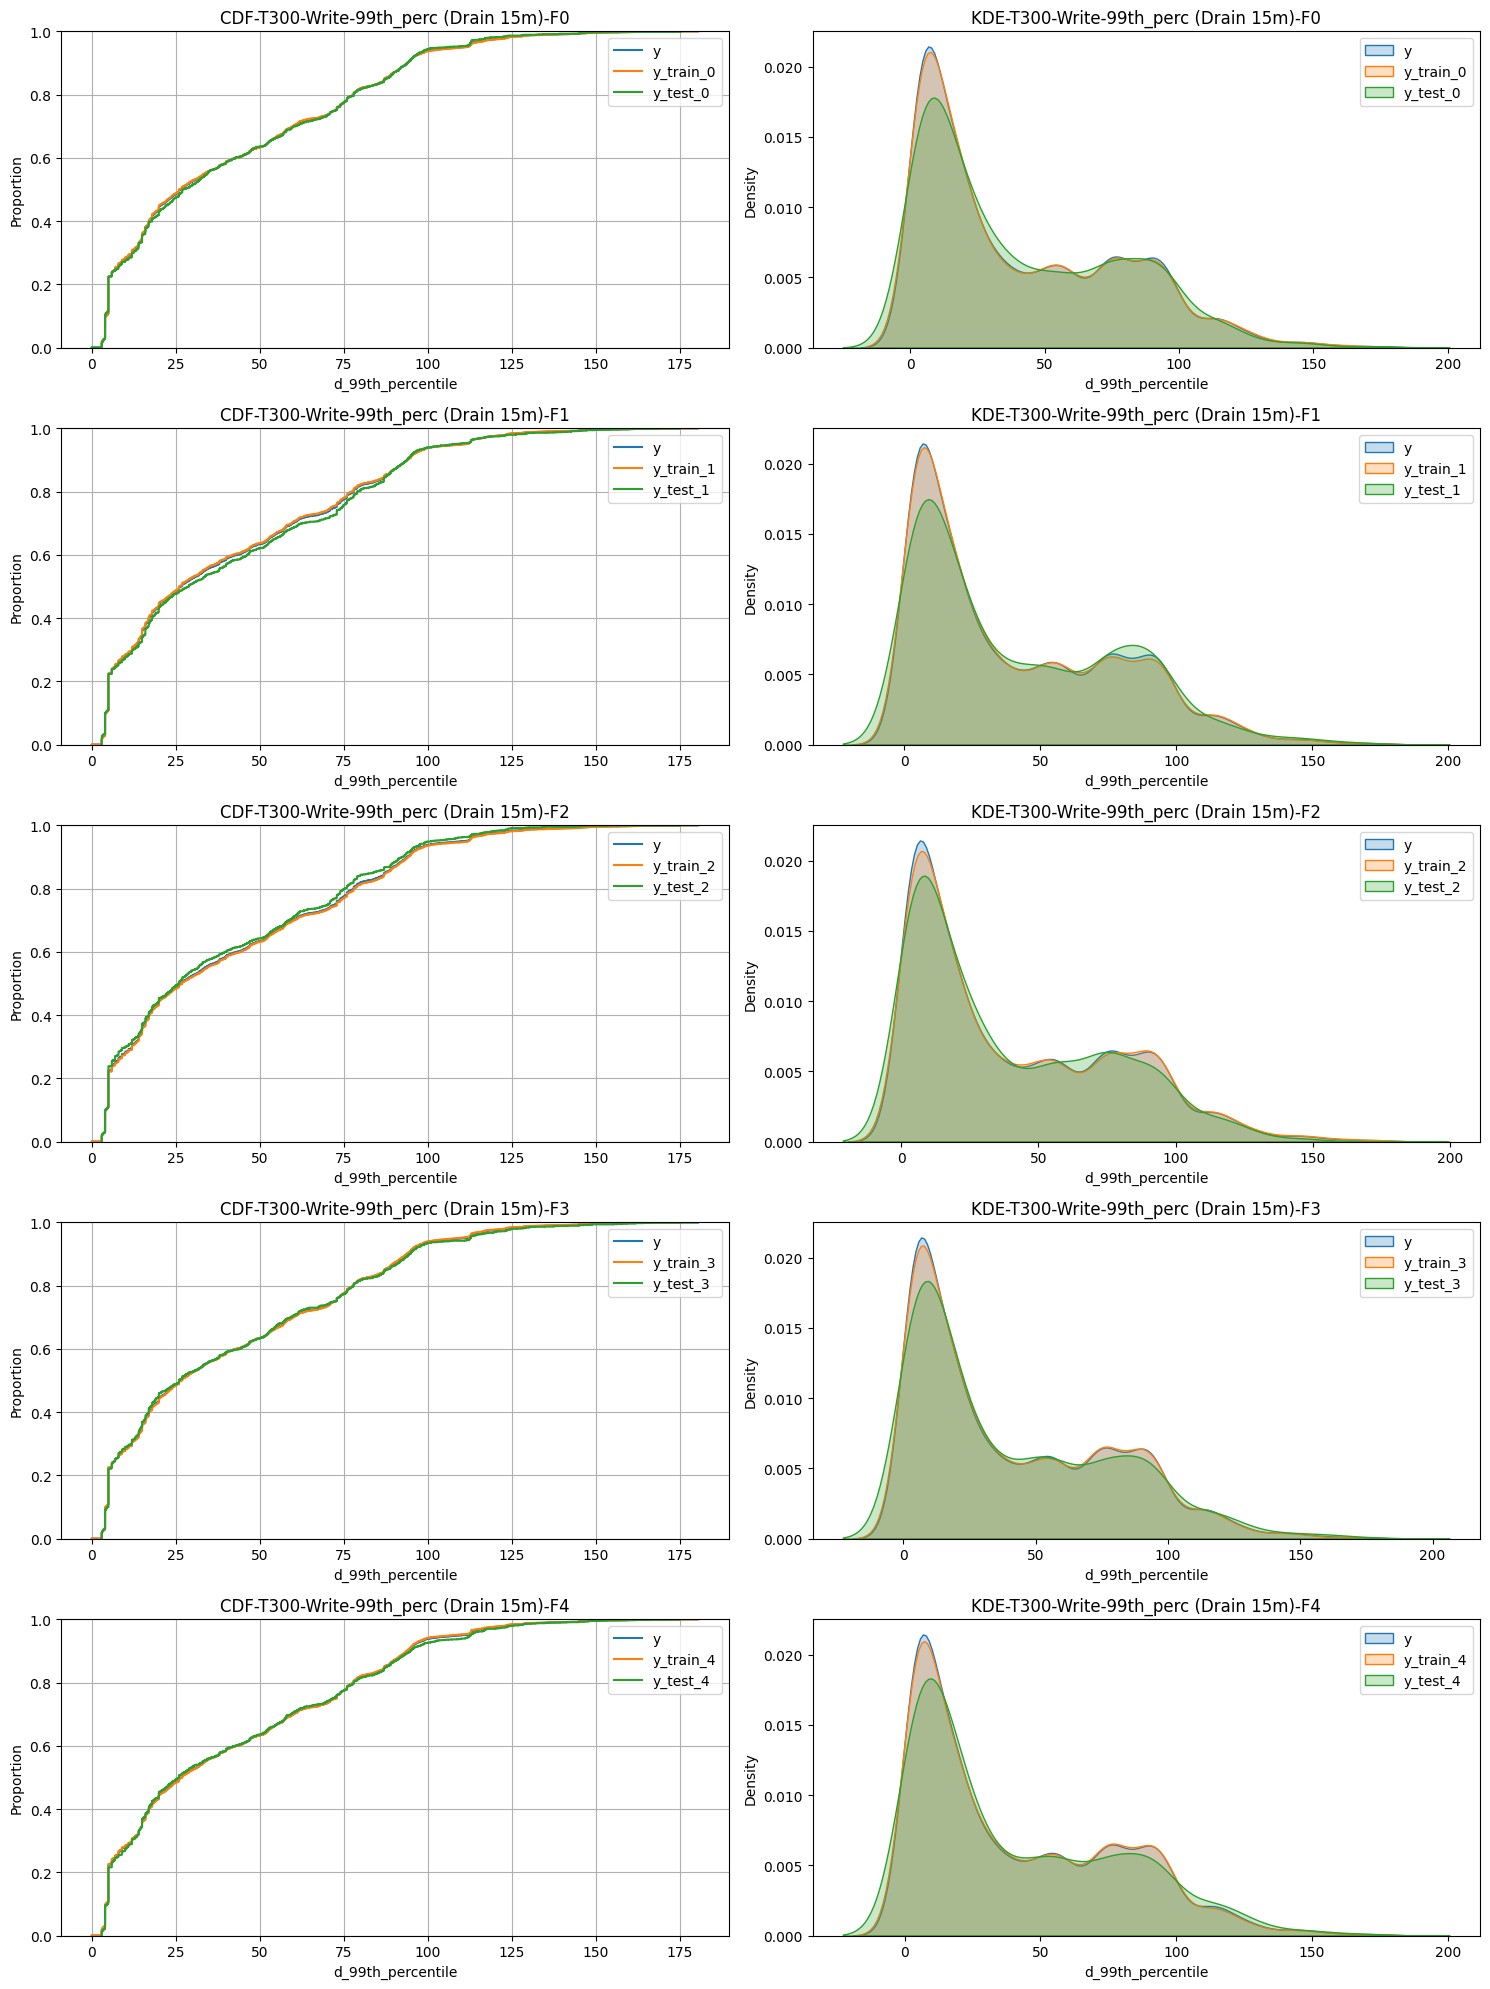

In [46]:
kfold_train_and_generate_plots(x_t300, y_t300, "d_99th_percentile", 5, "T300-Write-99th_perc (Drain 15m)", "images/exp_90c_2h")

T100 - Rand. Forest Training time: 156.657726s
Fold 1: 7.81%
Fold 2: 7.59%
Fold 3: 7.43%
Fold 4: 8.11%
Fold 5: 7.41%
Mean NMAE: 7.67%



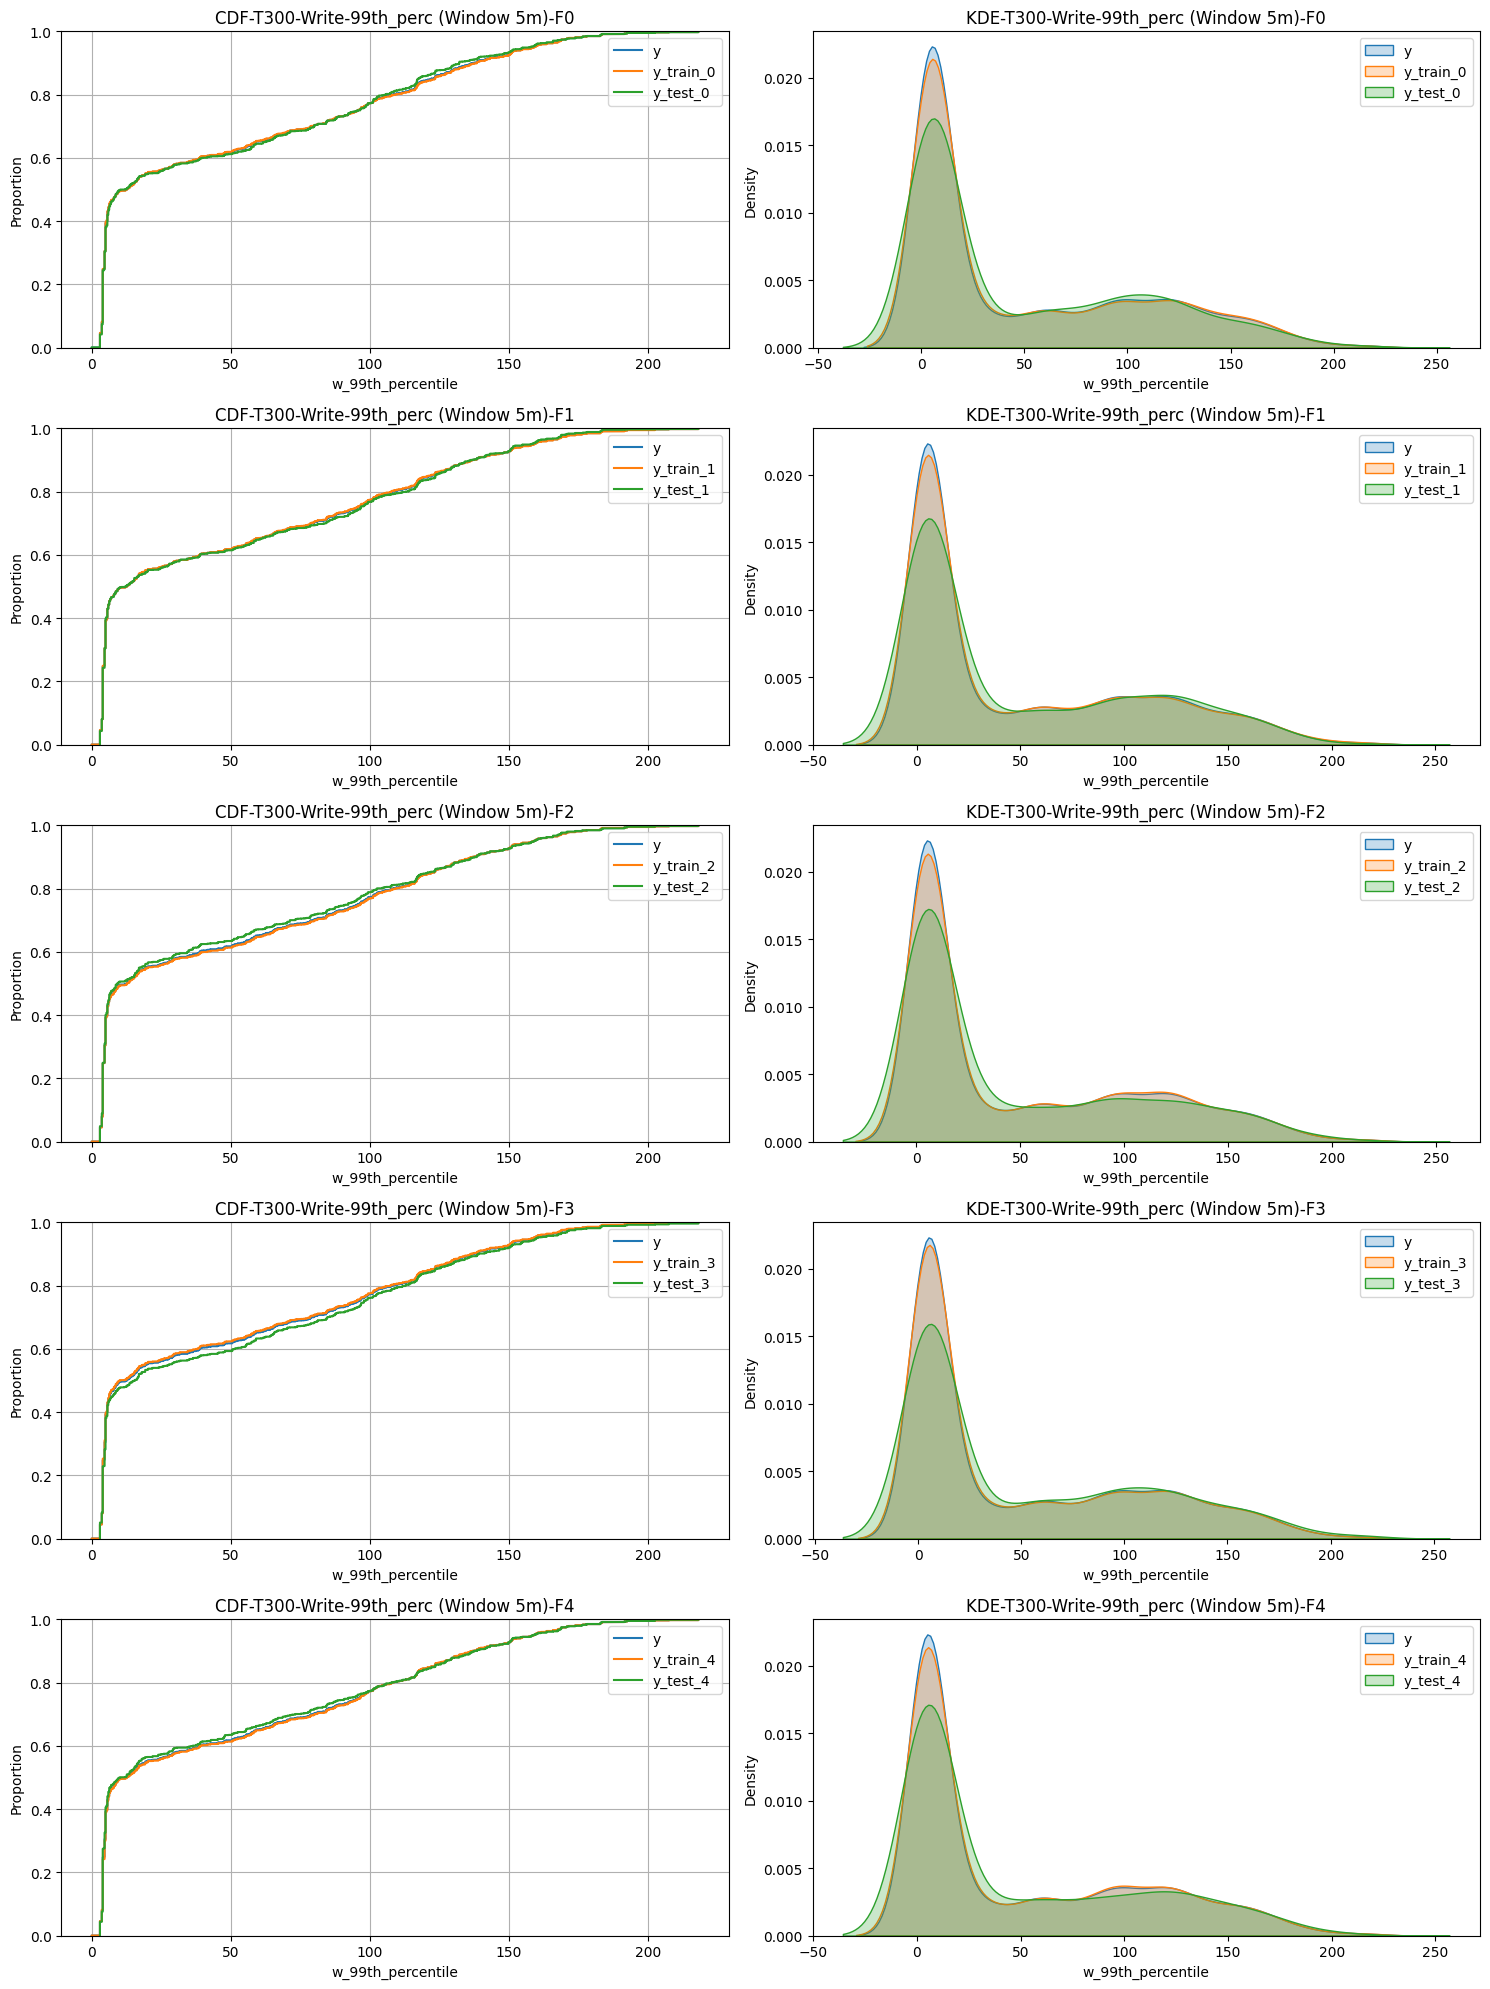

In [47]:
kfold_train_and_generate_plots(x_t300, y_t300, "w_99th_percentile", 5, "T300-Write-99th_perc (Window 5m)", "images/exp_90c_2h")

## T500

T100 - Rand. Forest Training time: 130.341552s
Fold 1: 0.07%
Fold 2: 0.08%
Fold 3: 0.07%
Fold 4: 0.08%
Fold 5: 0.07%
Mean NMAE: 0.08%



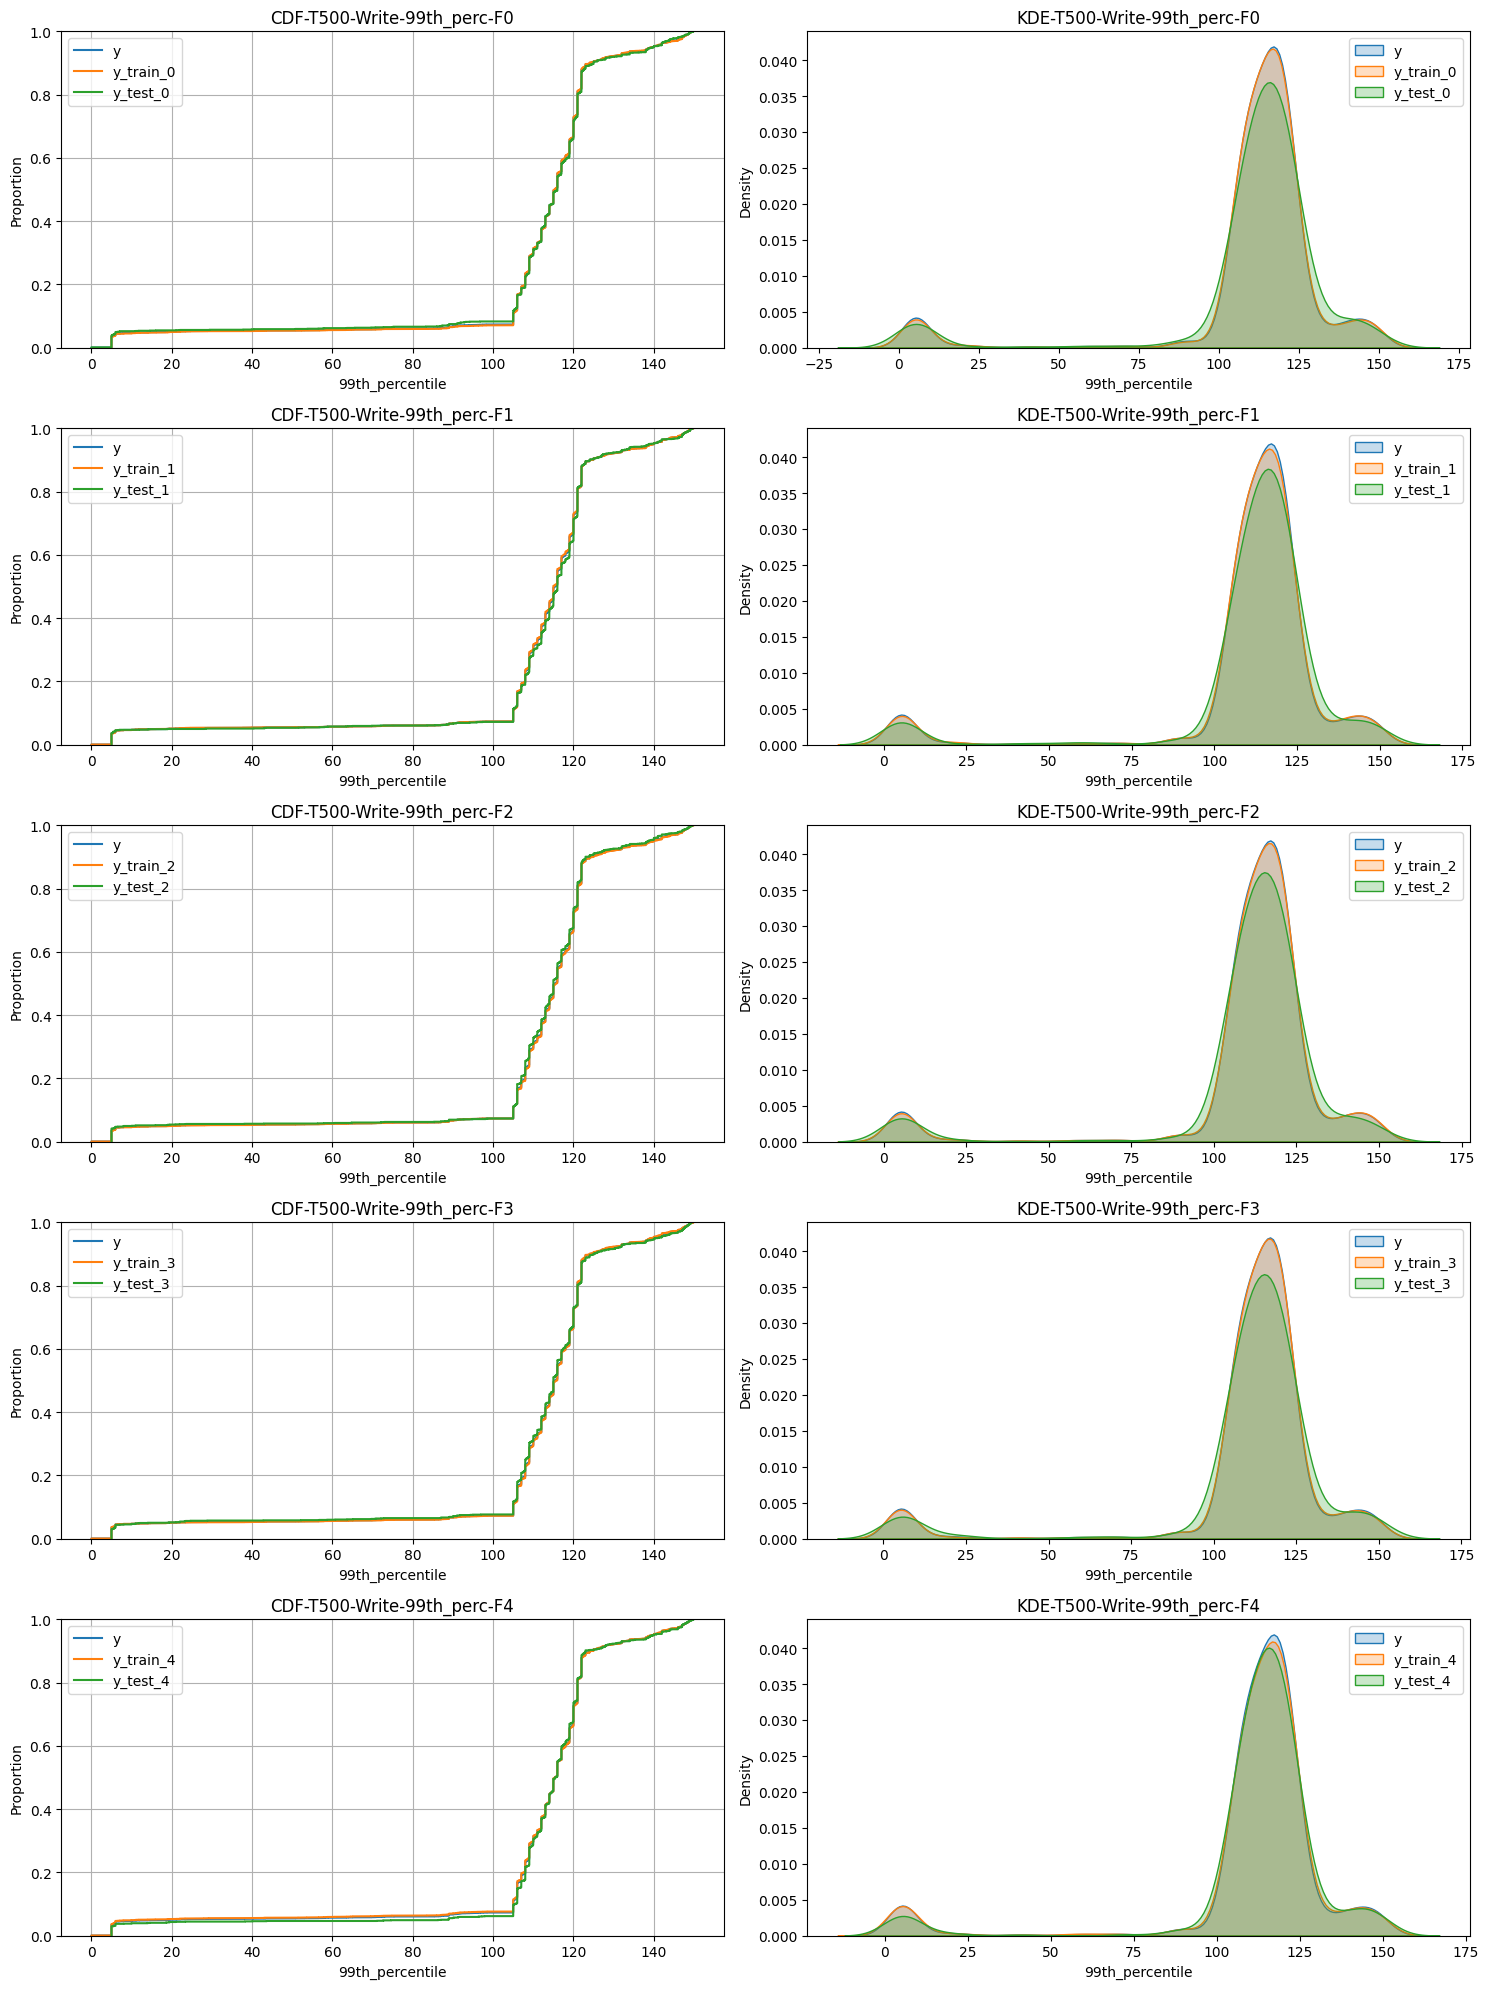

In [48]:
# Full dataset - wihout normalization...
kfold_train_and_generate_plots(x_t500, y_t500, "99th_percentile", 5, "T500-Write-99th_perc", "images/exp_90c_2h")

T100 - Rand. Forest Training time: 151.967253s
Fold 1: 1.44%
Fold 2: 1.29%
Fold 3: 1.47%
Fold 4: 1.87%
Fold 5: 1.34%
Mean NMAE: 1.48%



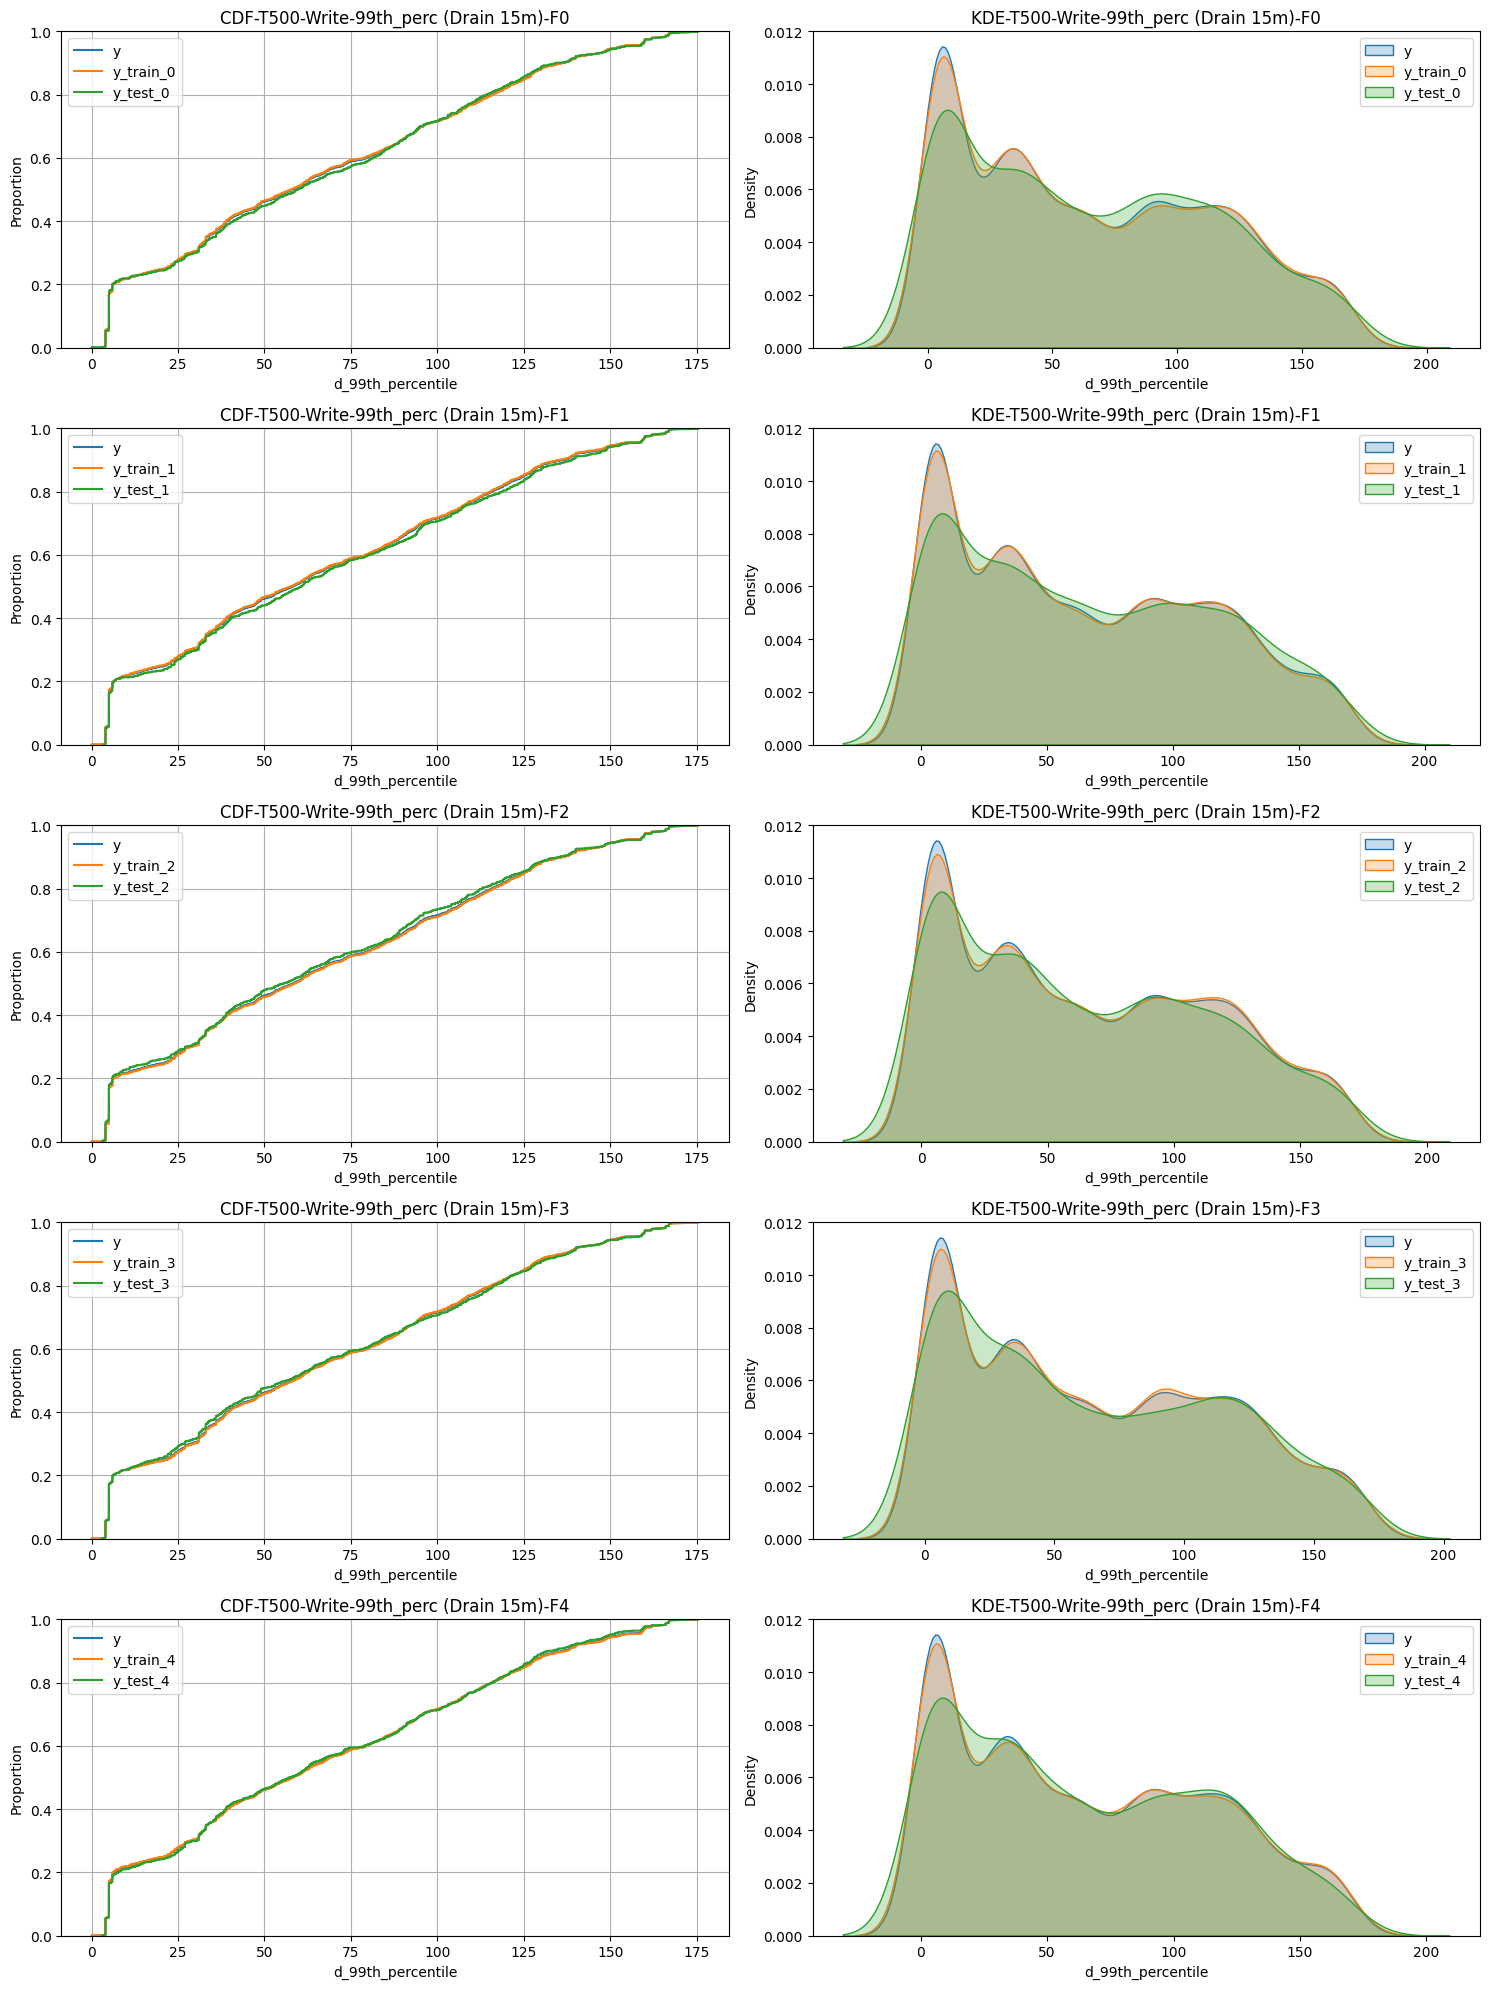

In [49]:
kfold_train_and_generate_plots(x_t500, y_t500, "d_99th_percentile", 5, "T500-Write-99th_perc (Drain 15m)", "images/exp_90c_2h")

T100 - Rand. Forest Training time: 213.19146s
Fold 1: 5.42%
Fold 2: 4.96%
Fold 3: 5.47%
Fold 4: 5.11%
Fold 5: 5.31%
Mean NMAE: 5.25%



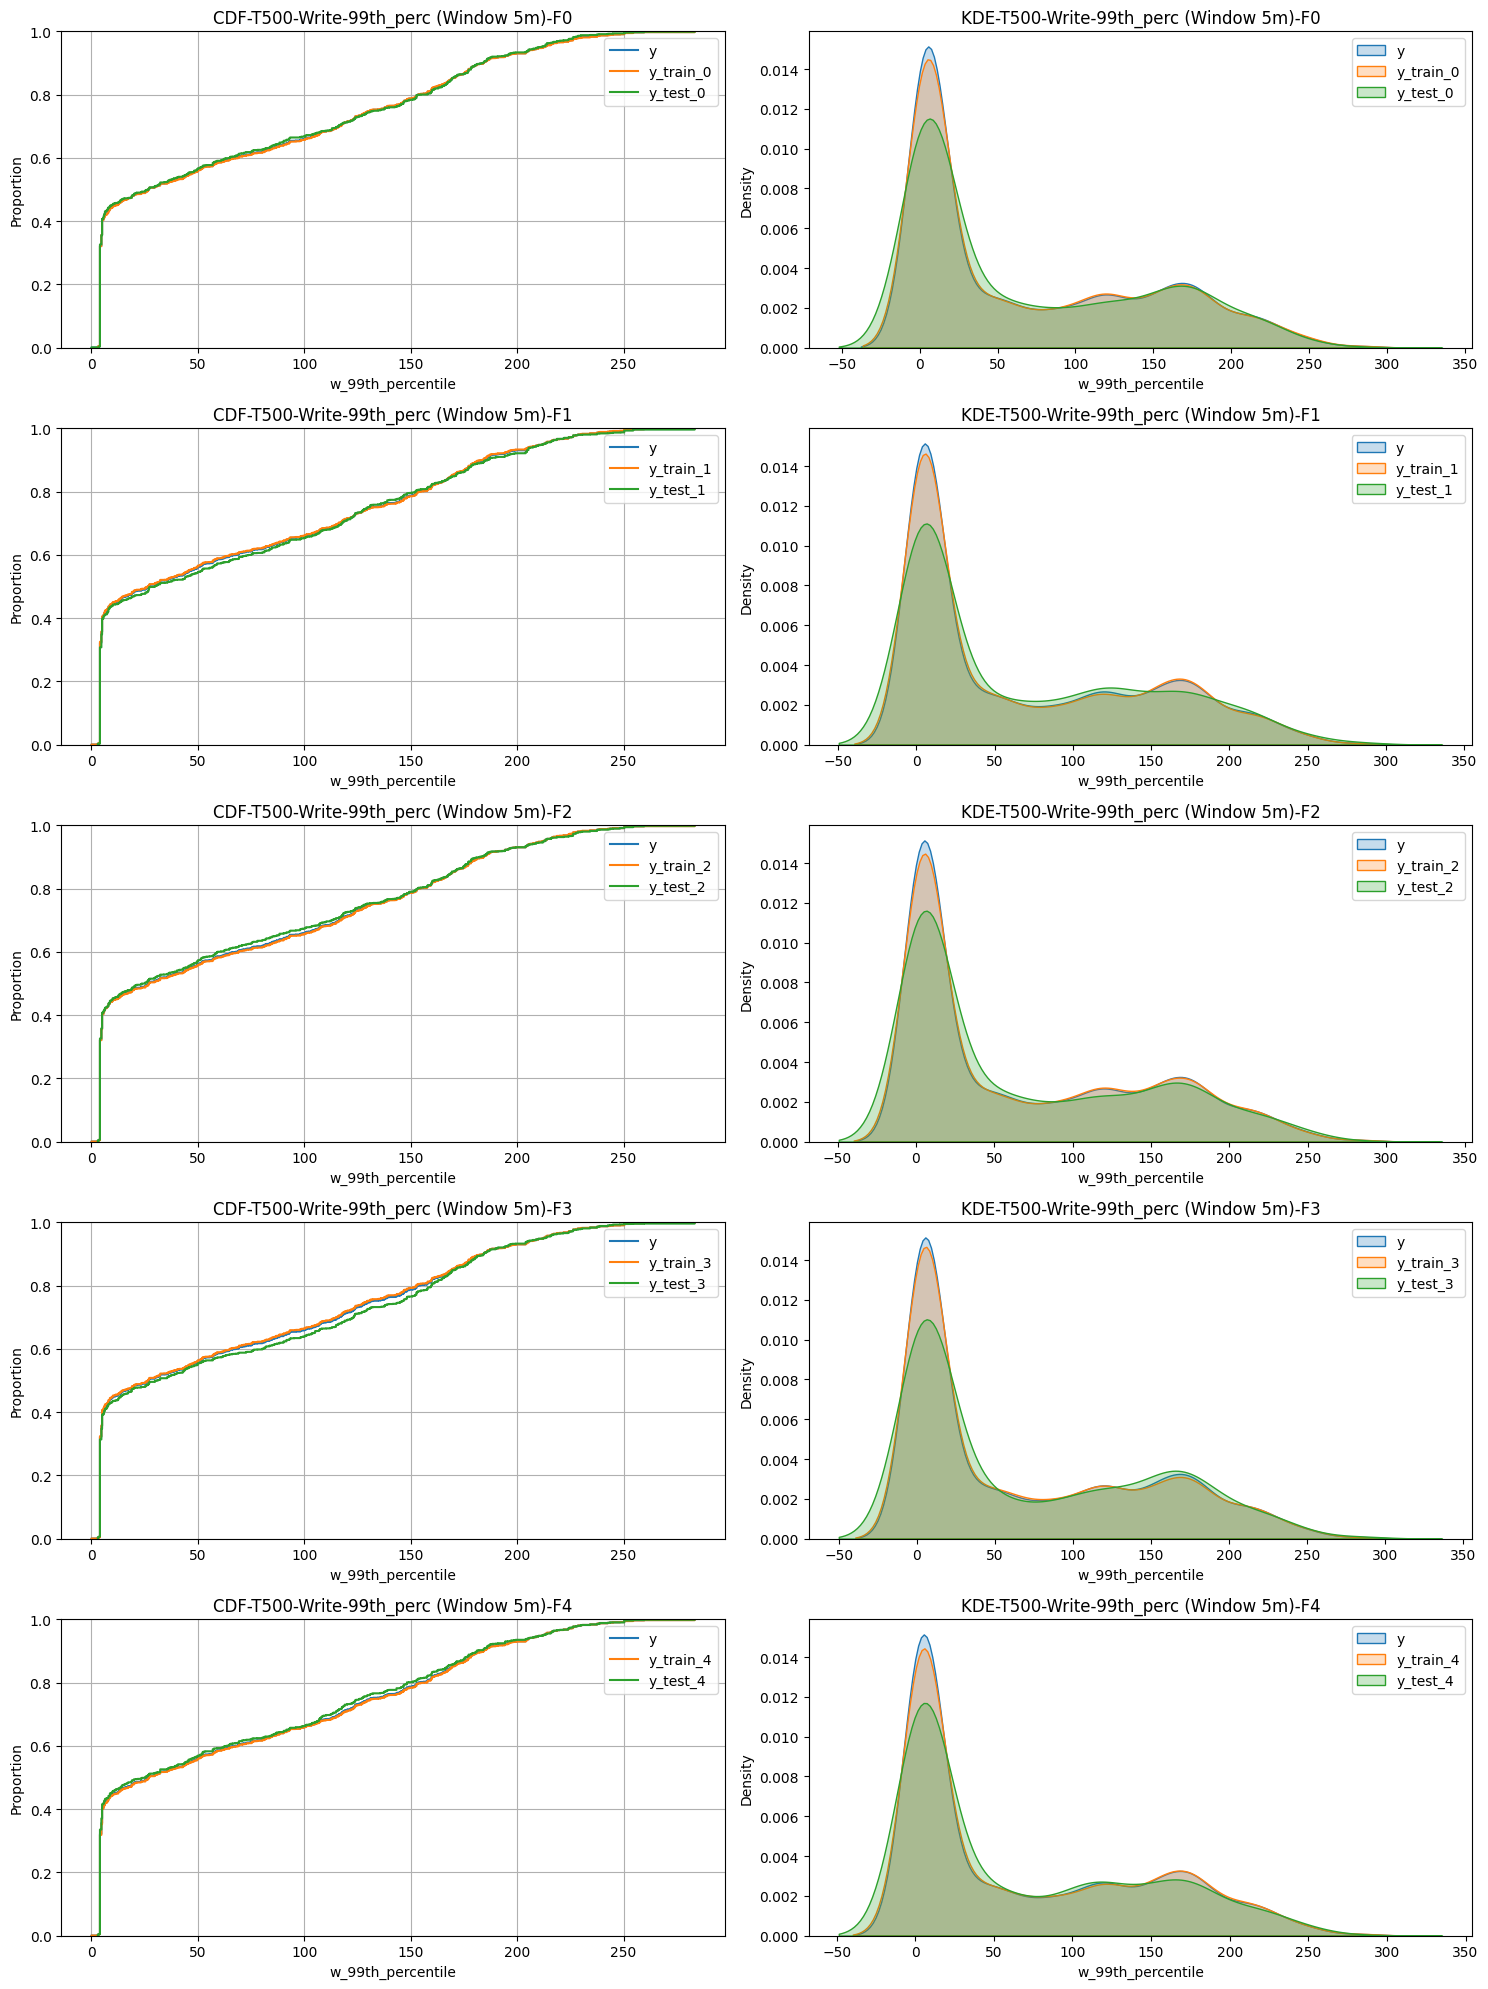

In [50]:
kfold_train_and_generate_plots(x_t500, y_t500, "w_99th_percentile", 5, "T500-Write-99th_perc (Window 5m)", "images/exp_90c_2h")

## Other models...

In [54]:
# Full dataset, using pipeline to normalize features and target.

# Define the feature pipeline
feature_pipeline = Pipeline([
    ('scaler', MinMaxScaler()), # Normalize input features
])

rf_regressor = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)

# Combine with target scaling using TransformedTargetRegressor
model = TransformedTargetRegressor(
    regressor=Pipeline([
        ('preprocess', feature_pipeline),
        ('model', rf_regressor)
    ]),
    transformer=MinMaxScaler()  # Normalizes the target y
)

# using 99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | 99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using d_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['d_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | d_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using w_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['w_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Rand. Forest Training time: 30.79498s
Full dataset | 99th_percentile -> Rand. Forest NMAE: 0.10%
Rand. Forest Training time: 52.514156s
Full dataset | d_99th_percentile -> Rand. Forest NMAE: 2.43%
Rand. Forest Training time: 73.947967s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 6.83%


In [55]:
# Full dataset, using xgboost

# 3. Initialize the XGBoost Regressor model
# objective='reg:squarederror' is the default for regression, but explicitly setting it is good practice.
# n_estimators controls the number of boosting rounds (trees).
# random_state for reproducibility.
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=42)

# using 99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | 99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using d_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['d_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | d_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

# using w_99th_percentile
x_train, x_test, y_train, y_test = train_test_split(x_ds_t300, y_ds_t300['w_99th_percentile'].to_numpy(), test_size=0.30, random_state=42)

time = datetime.datetime.now(tz=datetime.timezone.utc)
model.fit(x_train, y_train)
print(f'Rand. Forest Training time: {(datetime.datetime.now(tz=datetime.timezone.utc) - time).total_seconds()}s')

predicted = model.predict(x_test)
print(f'Full dataset | w_99th_percentile -> Rand. Forest NMAE: {nmae(predicted, y_test):.2%}')

Rand. Forest Training time: 25.202146s
Full dataset | 99th_percentile -> Rand. Forest NMAE: 0.09%
Rand. Forest Training time: 59.407267s
Full dataset | d_99th_percentile -> Rand. Forest NMAE: 3.09%
Rand. Forest Training time: 69.290943s
Full dataset | w_99th_percentile -> Rand. Forest NMAE: 5.87%
